## This program reads in streamflow data from CaMa physiology experiments at certain river locations to assess seasonal and temporal changes 
* Read in outflw at points along major global rivers

Written by Meg Fowler, 2018-05-03



In [1]:
import scipy as scipy
import scipy.stats as stats
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import ticker
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util
import time 
import xarray as xr
import pickle 
import os

from netCDF4 import Dataset
from matplotlib import ticker
from joblib import Parallel, delayed


In [3]:
#Get dimensions from a single file (same will be used for all files)
file1 = '/Users/meganfowler/gp_fuse/Flooding-physiology/Python/outflw1161.nc'
dat   = Dataset(file1)
lat   = dat.variables['lat'][:] 
lon   = dat.variables['lon'][:] 
days  = dat.variables['time'][:]

#Read in mask of which gridcells are land vs. ocean
matData   = sio.loadmat('/Users/meganfowler/gp_fuse/Flooding-physiology/MatlabData/validGridMask_CaMa.mat')
maskVal = matData['maskVal']
#Read in CaMa gridcell areas
matData = sio.loadmat('/Users/meganfowler/gp_fuse/Flooding-physiology/MatlabData/CaMa_gridAreas.mat')
area    = matData['area']

In [2]:
#Set filepaths 
# --- Need to mount: /lustre/DATA/pritchard/mdfowler/
ctrlDir = '/Users/meganfowler/gp_fuse/CaMaOutput_Physiology/global_15min_physiologyControl/'
# fullDir = '/Users/meganfowler/gp_fuse/CaMaOutput_Physiology/global_15min_physiologyFull/'
# physDir = '/Users/meganfowler/gp_fuse/CaMaOutput_Physiology/global_15min_physiologyPhysiology/'
# radDir  = '/Users/meganfowler/gp_fuse/CaMaOutput_Physiology/global_15min_physiologyRadiation/'


OSError: [Errno -101] NetCDF: HDF error: b'/beegfs/DATA/pritchard/mdfowler/CaMaOutput_Physiology/global_15min_physiologyFull/outflw1161.nc'

In [3]:
#Read in outflow data  
fCtrl_outflw = xr.open_dataset((ctrlDir + 'outflw30yr.nc'),decode_times=False)
# fFull_outflw = xr.open_dataset((fullDir + 'outflw30yr.nc'),decode_times=False)
# fPhys_outflw = xr.open_dataset((physDir + 'outflw30yr.nc'),decode_times=False)
# fRad_outflw  = xr.open_dataset((radDir  + 'outflw30yr.nc'),decode_times=False)


## Read in data at a single location and analyze river points at the outlet or upstream

In [4]:
#Set lat/lon locations for the mouth of the river, mid-point of the river, 
#    and an upstream point

riverNames = ['Amazon','Congo','Yangtze','Mississippi']

#Order right now: Amazon, Congo, Yangtze, and Mississippi
latMouth  = [-1.375,  -6.125,  32.125,  29.375]
lonMouth  = [-51.875, 12.375, 119.625, -89.375]
#Order right now: Amazon, Congo, Yangtze, and Mississippi
ilatMouth  = [365, 384, 231, 242]
ilonMouth  = [512, 769, 1198, 362]

ilatUpstrm = [374, 356,  240, 206]
ilonUpstrm = [475, 817, 1148, 358]



In [5]:
#Read in 30 years of daily data at one location 
# -- Takes ~18 minutes total

iReg = 3

ctrlRegOutflwO = fCtrl_outflw.isel(lat=slice(ilatMouth[iReg],ilatMouth[iReg]+1), lon=slice(ilonMouth[iReg],ilonMouth[iReg]+1))
fullRegOutflwO = fFull_outflw.isel(lat=slice(ilatMouth[iReg],ilatMouth[iReg]+1), lon=slice(ilonMouth[iReg],ilonMouth[iReg]+1))
physRegOutflwO = fPhys_outflw.isel(lat=slice(ilatMouth[iReg],ilatMouth[iReg]+1), lon=slice(ilonMouth[iReg],ilonMouth[iReg]+1))
radRegOutflwO  = fRad_outflw.isel(lat=slice(ilatMouth[iReg],ilatMouth[iReg]+1), lon=slice(ilonMouth[iReg],ilonMouth[iReg]+1))

ctrlRegOutflw = fCtrl_outflw.isel(lat=slice(ilatUpstrm[iReg],ilatUpstrm[iReg]+1), lon=slice(ilonUpstrm[iReg],ilonUpstrm[iReg]+1))
fullRegOutflw = fFull_outflw.isel(lat=slice(ilatUpstrm[iReg],ilatUpstrm[iReg]+1), lon=slice(ilonUpstrm[iReg],ilonUpstrm[iReg]+1))
physRegOutflw = fPhys_outflw.isel(lat=slice(ilatUpstrm[iReg],ilatUpstrm[iReg]+1), lon=slice(ilonUpstrm[iReg],ilonUpstrm[iReg]+1))
radRegOutflw  = fRad_outflw.isel(lat=slice(ilatUpstrm[iReg],ilatUpstrm[iReg]+1), lon=slice(ilonUpstrm[iReg],ilonUpstrm[iReg]+1))
print('Files extracted')
                                 
t1 = time.time()
dailyOutflwCtrlOutlet = ctrlRegOutflwO.outflw.values
dailyOutflwFullOutlet = fullRegOutflwO.outflw.values
dailyOutflwPhysOutlet = physRegOutflwO.outflw.values
dailyOutflwRadOutlet  = radRegOutflwO.outflw.values

dailyOutflwCtrl = ctrlRegOutflw.outflw.values
dailyOutflwFull = fullRegOutflw.outflw.values
dailyOutflwPhys = physRegOutflw.outflw.values
dailyOutflwRad  = radRegOutflw.outflw.values
print('Time to read in outflow data: ', (time.time()-t1))


Files extracted
Time to read in outflow data:  2021.8536887168884


In [6]:
timeCtrl = ctrlRegOutflw.time.values  #Read in time values for CTRL
timeNew  = range(0,len(timeCtrl))     #Make new 'time' array counting days of experiment
#len(timeNew)
np.min(dailyOutflwCtrl[:,0,0])

970.38446

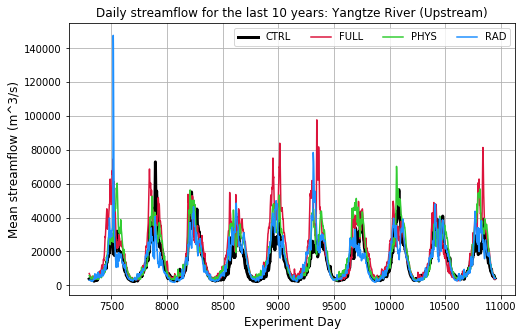

In [7]:
# Look at time series of daily data: 
fig=plt.figure(figsize=(8,5), facecolor='w', edgecolor='k')
my_fontsize = 12
## --- Set axes and size sections --- 
#fig, ax = plt.subplots(1,1,subplot_kw={'projection':ccrs.PlateCarree()})
plt.plot(timeNew[7300:],dailyOutflwCtrl[7300:,0,0],color ='Black',label='CTRL',linewidth=3)
plt.plot(timeNew[7300:],dailyOutflwFull[7300:,0,0],color ='Crimson',label='FULL')
plt.plot(timeNew[7300:],dailyOutflwPhys[7300:,0,0],color = 'LimeGreen',label='PHYS')
plt.plot(timeNew[7300:],dailyOutflwRad[7300:,0,0],color='DodgerBlue',label='RAD')
plt.legend(fontsize=10,ncol=4)
plt.title('Daily streamflow for the last 10 years: '+riverNames[iReg]+ ' River (Upstream)',fontsize=my_fontsize)
plt.xlabel('Experiment Day',fontsize=my_fontsize)
plt.ylabel('Mean streamflow (m^3/s)',fontsize=my_fontsize)
plt.grid()

#fig.savefig('/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/Regional/DailyOutflw_'+riverNames[iReg]+'Upstream-10yr.jpg')  #Save figure as PDF

### That's still pretty messy - a seasonal composite would be much easier to see, I think...

* Need to find all Jan,Feb,Mar, etc... and average those together


In [10]:
#Reshape time dimension to be 30 years x 365 days 
timeCtrl = np.reshape(timeNew,[30,365])
#ctrlFlw  = np.reshape(dailyOutflwCtrl[:,0,0],[30,365])
#fullFlw  = np.reshape(dailyOutflwFull[:,0,0],[30,365])
#physFlw  = np.reshape(dailyOutflwPhys[:,0,0],[30,365])
#radFlw   = np.reshape(dailyOutflwRad[:,0,0],[30,365])

ctrlFlw  = np.reshape(dailyOutflwCtrlOutlet[:,0,0],[30,365])
fullFlw  = np.reshape(dailyOutflwFullOutlet[:,0,0],[30,365])
physFlw  = np.reshape(dailyOutflwPhysOutlet[:,0,0],[30,365])
radFlw   = np.reshape(dailyOutflwRadOutlet[:,0,0],[30,365])


In [11]:
#Define empty arrays to store monthly averages 
avgCtrl  = np.full([30,12],np.nan)
avgFull  = np.full([30,12],np.nan)
avgPhys  = np.full([30,12],np.nan)
avgRad   = np.full([30,12],np.nan)
#seCtrl  = np.full([12],np.nan)
#seFull  = np.full([12],np.nan)
#sePhys  = np.full([12],np.nan)
#seRad   = np.full([12],np.nan)

#Beginning/ending julian days for each month
startInd = [0, 31,59, 90,120,151,181,212,243,273,304,334]
endInd   = [30,58,89,119,150,180,211,242,272,303,333,364]

for iMon in range(12):
    monthCtrl = ctrlFlw[:,startInd[iMon]:endInd[iMon]+1]
    monthFull = fullFlw[:,startInd[iMon]:endInd[iMon]+1]
    monthPhys = physFlw[:,startInd[iMon]:endInd[iMon]+1]
    monthRad  = radFlw[:,startInd[iMon]:endInd[iMon]+1]
    
    avgCtrl[:,iMon] = np.nanmean(monthCtrl,axis=1)
    avgFull[:,iMon] = np.nanmean(monthFull,axis=1)
    avgPhys[:,iMon] = np.nanmean(monthPhys,axis=1)
    avgRad[:,iMon]  = np.nanmean(monthRad,axis=1)
    
    #Compute error bars as the standard error using daily data
    #seCtrl[iMon] = np.std(np.reshape(monthCtrl,[np.size(monthCtrl),1]),axis=0) / np.sqrt(np.size(monthCtrl))
    #seFull[iMon] = np.std(np.reshape(monthFull,[np.size(monthFull),1]),axis=0) / np.sqrt(np.size(monthFull))
    #sePhys[iMon] = np.std(np.reshape(monthPhys,[np.size(monthPhys),1]),axis=0) / np.sqrt(np.size(monthPhys))
    #seRad[iMon]  = np.std(np.reshape(monthRad,[np.size(monthRad),1]),axis=0)   / np.sqrt(np.size(monthRad))
    
#Compute seasonal cycle 
seasonalCtrl = np.nanmean(avgCtrl,axis=0)
seasonalFull = np.nanmean(avgFull,axis=0)
seasonalPhys = np.nanmean(avgPhys,axis=0)
seasonalRad  = np.nanmean(avgRad,axis=0)

#Compute error bars as the standard error using monthly data
seCtrl_mon = np.std(avgCtrl,axis=0) / np.sqrt(30)
seFull_mon = np.std(avgFull,axis=0) / np.sqrt(30)
sePhys_mon = np.std(avgPhys,axis=0) / np.sqrt(30)
seRad_mon = np.std(avgRad,axis=0) / np.sqrt(30)


([<matplotlib.axis.XTick at 0x2aec2c69bc18>,
 <a list of 12 Text xticklabel objects>)

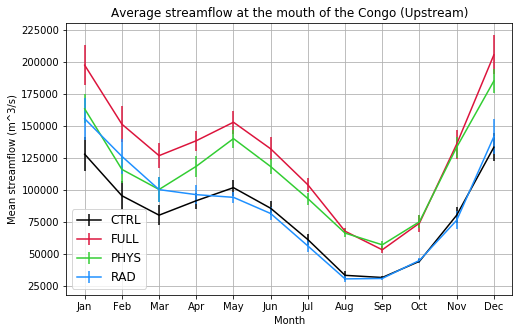

In [15]:
# Look at average seasonal cycle 

fig=plt.figure(figsize=(8,5), facecolor='w', edgecolor='k')
my_fontsize = 12
## Plot seasonal cycle 
plt.errorbar(range(12),seasonalCtrl,yerr=2*seCtrl_mon,color ='Black',    label='CTRL')
plt.errorbar(range(12),seasonalFull,yerr=2*seFull_mon,color ='Crimson',  label='FULL')
plt.errorbar(range(12),seasonalPhys,yerr=2*sePhys_mon,color ='LimeGreen',label='PHYS')
plt.errorbar(range(12),seasonalRad,yerr=2*seRad_mon, color='DodgerBlue',label='RAD')
#Extra plot options
plt.legend(fontsize=my_fontsize)
plt.title('Average streamflow at the mouth of the '+riverNames[iReg]+' (Upstream)',fontsize=my_fontsize)
plt.xlabel('Month')
plt.ylabel('Mean streamflow (m^3/s)')
plt.xlim(-0.5,11.5)
plt.grid()
plt.xticks(range(12), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

#fig.savefig('/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/Regional/SeasonalMeanOutflw_'+riverNames[iReg]+'Upstream-30yr.pdf')  #Save figure as PDF
#plt.close(fig)


### How does the variability change? 

In [35]:
print('Avg Control:         ', np.min(seasonalCtrl), np.max(seasonalCtrl))
print('Avg Phys:            ', np.min(seasonalPhys), np.max(seasonalPhys))
print('Avg %-change in Ctrl:', (np.max(seasonalCtrl)-np.min(seasonalCtrl))/np.min(seasonalCtrl)*100)
print('Avg %-change in Phys:', (np.max(seasonalPhys)-np.min(seasonalPhys))/np.min(seasonalPhys)*100)

print()
print('... Below are from averaging yearly min/max ...')
print('Yearly averages Phys:', np.mean(np.min(avgPhys,axis=1)), np.mean(np.max(avgPhys,axis=1)))
print('Avg %-Change in Phys:', np.mean((np.max(avgPhys,axis=1)-np.min(avgPhys,axis=1))/np.min(avgPhys,axis=1))*100)

Avg Control:          3168.635294596354 30320.546223958332
Avg Phys:             4210.399576822917 39864.66705729167
Avg %-change in Ctrl: 856.8960579232835
Avg %-change in Phys: 846.8143422000995

... Below are from averaging yearly min/max ...
Yearly averages Phys: 3974.0481119791666 44137.316796875
Avg %-Change in Phys: 1037.991800996147


In [11]:
# To start, let's just take a look at seasonal differences 

minCtrl    = np.min(avgCtrl,axis=1)
maxCtrl    = np.max(avgCtrl,axis=1)
seasonCtrl = np.mean(maxCtrl-minCtrl)
pctCtrl    = np.mean((maxCtrl-minCtrl)/minCtrl) * 100

minFull    = np.min(avgFull,axis=1)
maxFull    = np.max(avgFull,axis=1)
seasonFull = np.mean(maxFull-minFull)
pctFull    = np.mean((maxFull-minFull)/minFull)*100

minPhys    = np.min(avgPhys,axis=1)
maxPhys    = np.max(avgPhys,axis=1)
seasonPhys = np.mean(maxPhys-minPhys)
pctPhys    = np.mean((maxPhys-minPhys)/minPhys)*100

minRad     = np.min(avgRad,axis=1)
maxRad     = np.max(avgRad,axis=1)
seasonRad  = np.mean(maxRad-minRad)
pctRad     = np.mean((maxRad-minRad)/minRad)*100

print('')
print('------------------ Average seasonal difference --------------------')
print('Computed as difference between max and min months in 30-year record')
print('(Outlet) River: ', riverNames[iReg])
print('')
print("CTRL:  %.2e  m^3/s (%.1f %% increase over min)" % (seasonCtrl, pctCtrl))
print("FULL:  %.2e  m^3/s (%.1f %% increase over min)" % (seasonFull, pctFull))
print("PHYS:  %.2e  m^3/s (%.1f %% increase over min)" % (seasonPhys, pctPhys))
print("RAD:   %.2e  m^3/s (%.1f %% increase over min)" % (seasonRad,  pctRad))
print('')
print



------------------ Average seasonal difference --------------------
Computed as difference between max and min months in 30-year record
(Outlet) River:  Yangtze

CTRL:  3.13e+04  m^3/s (1056.1 % increase over min)
FULL:  4.45e+04  m^3/s (1170.3 % increase over min)
PHYS:  4.02e+04  m^3/s (1038.0 % increase over min)
RAD:   3.45e+04  m^3/s (1169.8 % increase over min)



<function print>

In [ ]:
print(pctCtrl)

<div class="alert alert-block alert-warning">

<font color=green> **How else could we measure variability??** </font>
<br> 
This is a pretty simplistic measure above... what about the coefficient of variation? 
<br>
The coefficient of variation is the standard deviation divided by the average annual rainfall. So it can tell you that 67% of the time (1 std), streamflow could vary by +/- CV*100 %. 

source: http://tornado.sfsu.edu/geosciences/classes/m356/RainfallVariability/TempVar.htm
<br>
<br>  
The larger the CV the more variable the year-to-year streamflow is. 
<br>
source: http://planet.uwc.ac.za/nisl/Invasives/Assignments/GARP/atlas/atlas_36t.htm
 
<br> 
<br> 
This study uses CV to estimate year-to-year stream flow variability 
<br>
source: https://journals.ametsoc.org/doi/pdf/10.1175/1525-7541%282000%29001%3C0289%3AGCOSFS%3E2.0.CO%3B2

</div>



In [18]:
# Let's compute CV - measure over all the daily data 

CVctrl = (np.std(dailyOutflwCtrl,axis=0) / np.mean(dailyOutflwCtrl,axis=0))*100
CVfull = (np.std(dailyOutflwFull,axis=0) / np.mean(dailyOutflwFull,axis=0))*100
CVphys = (np.std(dailyOutflwPhys,axis=0) / np.mean(dailyOutflwPhys,axis=0))*100
CVrad = (np.std(dailyOutflwRad,axis=0) / np.mean(dailyOutflwRad,axis=0))*100


print('')
print('------------------ Coefficient of Variation --------------------')
print('(Upstream) River: ', riverNames[iReg])
print('')
print("CTRL:  %.2f %% " % CVctrl)
print("FULL:  %.2f %% " % CVfull)
print("PHYS:  %.2f %% " % CVphys)
print("RAD:   %.2f %% " % CVrad)
print('')



------------------ Coefficient of Variation --------------------
(Upstream) River:  Mississippi

CTRL:  30.76 % 
FULL:  36.63 % 
PHYS:  27.89 % 
RAD:   34.42 % 



<div class="alert alert-block alert-warning">

<font color=green> **A second view on seasonality/variability changes** </font>
<br> 
* Bar plots of standard deviation within each month over the 30-year record. 
<br>
* Stacked bar charts of monthly changes.

Text(0.5,1,'Average streamflow at the mouth of the Yangtze (Upstream)')

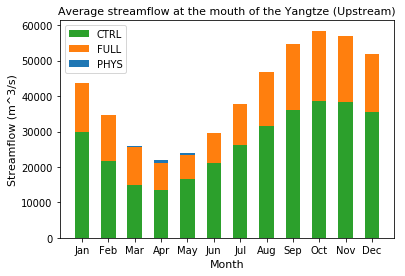

In [23]:
# Plot as a single bar chart instead of a line plot - is it more compelling/easier to read? 

nmon = 12
ind = np.arange(nmon)
width = 0.55

p3 = plt.bar(ind, seasonalPhys,width)
p2 = plt.bar(ind, seasonalFull, width)
p1 = plt.bar(ind, seasonalCtrl, width)
plt.xticks(ind,('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'))
plt.legend((p1[0],p2[0],p3[0]),('CTRL','FULL','PHYS'))
plt.xlabel('Month',fontsize=11)
plt.ylabel('Streamflow (m^3/s)',fontsize=11)
plt.title('Average streamflow at the mouth of the '+riverNames[iReg]+' (Upstream)',fontsize=11)




In [12]:
# Are there changes in which months have the highest/lowest streamflow? 

sortedCtrl = np.sort(seasonalCtrl)[::-1]
sortedFull = np.sort(seasonalFull)[::-1]
sortedPhys = np.sort(seasonalPhys)[::-1]
sortedRad  = np.sort(seasonalRad)[::-1]

iMaxCtrl = np.where(seasonalCtrl>=sortedCtrl[2])
iMaxFull = np.where(seasonalFull>=sortedFull[2])
iMaxPhys = np.where(seasonalPhys>=sortedPhys[2])
iMaxRad  = np.where(seasonalRad>=sortedRad[2])

iMinCtrl = np.where(seasonalCtrl<=sortedCtrl[9])
iMinFull = np.where(seasonalFull<=sortedFull[9])
iMinPhys = np.where(seasonalPhys<=sortedPhys[9])
iMinRad  = np.where(seasonalRad<=sortedRad[9])

print()
print(riverNames[iReg], '(Outlet): ')
print('Months with the highest streamflow: ')
print('   Ctrl top months: ', iMaxCtrl, '  Average flow: ',np.mean(seasonalCtrl[iMaxCtrl]))
print('   Full top months: ', iMaxFull, '  Average flow: ',np.mean(seasonalFull[iMaxFull]))
print('   Phys top months: ', iMaxPhys, '  Average flow: ',np.mean(seasonalPhys[iMaxPhys]))
print('   Rad top months:  ', iMaxRad,  '  Average flow: ',np.mean(seasonalRad[iMaxRad]))

print('')
print('Months with the lowest streamflow: ')
print('   Ctrl low months: ', iMinCtrl, '  Average flow: ',np.mean(seasonalCtrl[iMinCtrl]))
print('   Full low months: ', iMinFull, '  Average flow: ',np.mean(seasonalFull[iMinFull]))
print('   Phys low months: ', iMinPhys, '  Average flow: ',np.mean(seasonalPhys[iMinPhys]))
print('   Rad low months:  ', iMinRad,  '  Average flow: ',np.mean(seasonalRad[iMinRad]))
print('')



Mississippi (Outlet): 
Months with the highest streamflow: 
   Ctrl top months:  (array([4, 5, 6]),)   Average flow:  13260.68425564236
   Full top months:  (array([4, 5, 6]),)   Average flow:  21750.596028645832
   Phys top months:  (array([4, 5, 6]),)   Average flow:  16998.881217447917
   Rad top months:   (array([4, 5, 6]),)   Average flow:  19575.284874131947

Months with the lowest streamflow: 
   Ctrl low months:  (array([ 0, 10, 11]),)   Average flow:  7112.2958984375
   Full low months:  (array([ 0, 10, 11]),)   Average flow:  9577.234602864584
   Phys low months:  (array([ 0, 10, 11]),)   Average flow:  8128.161420355903
   Rad low months:   (array([ 0,  1, 11]),)   Average flow:  8063.820320638021



## Can we make global maps of seasonal amplitude and its change? 
* Make monthly averages 
* Compute annual seasonal amplitude 

In [4]:
# -- Test one year -- 
#Define beginning of path to each file
mainDir = '/beegfs/DATA/pritchard/mdfowler/CaMaOutput_Physiology/'
ctrlDir = mainDir+'global_15min_physiologyControl/outflw'
fullDir = mainDir+'global_15min_physiologyFull/outflw'
physDir = mainDir+'global_15min_physiologyPhysiology/outflw'
radDir  = mainDir+'global_15min_physiologyRadiation/outlfw'

years = np.arange(1161,1191)
i=0

fCtrl = xr.open_dataset((ctrlDir+str(years[i])+'.nc'),decode_times=False)
#dailyOutflwCtrl = fCtrl.outflw.values
#np.shape(dailyOutflwCtrl)

In [7]:
np.shape(fCtrl.outflw)

(365, 720, 1440)

In [10]:
# Do one year at a time 
years = np.arange(1161,1191)
nlat = len(fCtrl.lat)
nlon = len(fCtrl.lon)

# #Define empty arrays to store monthly averages 
# avgCtrl  = np.full([30,12,nlat,nlon],np.nan)
# avgFull  = np.full([30,12,nlat,nlon],np.nan)
# avgPhys  = np.full([30,12,nlat,nlon],np.nan)
# avgRad   = np.full([30,12,nlat,nlon],np.nan)

#Define empty arrays to store extreme flows (high/low)
minCtrl_ann = np.full([30,nlat,nlon],np.nan)
maxCtrl_ann = np.full([30,nlat,nlon],np.nan)
minFull_ann = np.full([30,nlat,nlon],np.nan)
maxFull_ann = np.full([30,nlat,nlon],np.nan)
minPhys_ann = np.full([30,nlat,nlon],np.nan)
maxPhys_ann = np.full([30,nlat,nlon],np.nan)
minRad_ann  = np.full([30,nlat,nlon],np.nan)
maxRad_ann  = np.full([30,nlat,nlon],np.nan)

ctrl95_ann = np.full([30,nlat,nlon],np.nan) #High flow (exceeded 5% of the time each year)
ctrl5_ann  = np.full([30,nlat,nlon],np.nan) #Low flow (exceeded 95% of the time each year)
full95_ann = np.full([30,nlat,nlon],np.nan)
full5_ann  = np.full([30,nlat,nlon],np.nan)
phys95_ann = np.full([30,nlat,nlon],np.nan)
phys5_ann  = np.full([30,nlat,nlon],np.nan)
rad95_ann  = np.full([30,nlat,nlon],np.nan)
rad5_ann   = np.full([30,nlat,nlon],np.nan)

# ctrl95_allYr = np.full([nlat,nlon],np.nan) #High flow (exceeded 5% of the time over all 30 years)
# ctrl5_allYr  = np.full([nlat,nlon],np.nan) #Low flow (exceeded 95% of the time each year)
# full95_allYr = np.full([nlat,nlon],np.nan)
# full5_allYr  = np.full([nlat,nlon],np.nan)
# phys95_allYr = np.full([nlat,nlon],np.nan)
# phys5_allYr  = np.full([nlat,nlon],np.nan)
# rad95_allYr  = np.full([nlat,nlon],np.nan)
# rad5_allYr   = np.full([nlat,nlon],np.nan)

#Beginning/ending julian days for each month
startInd = [0, 31,59, 90,120,151,181,212,243,273,304,334]
endInd   = [30,58,89,119,150,180,211,242,272,303,333,364]

#Define beginning of path to each file
mainDir = '/beegfs/DATA/pritchard/mdfowler/CaMaOutput_Physiology/'
ctrlDir = mainDir+'global_15min_physiologyControl/outflw'
fullDir = mainDir+'global_15min_physiologyFull/outflw'
physDir = mainDir+'global_15min_physiologyPhysiology/outflw'
radDir  = mainDir+'global_15min_physiologyRadiation/outflw'

print('Startin on yearly loop...')
#Create monthly averages from yearly files 
for i in range(len(years)):
    t1 = time.time()
    
    #Retrieve file via xarray 
    fCtrl = xr.open_dataset((ctrlDir+str(years[i])+'.nc'),decode_times=False)
    fFull = xr.open_dataset((fullDir+str(years[i])+'.nc'),decode_times=False)
    fPhys = xr.open_dataset((physDir+str(years[i])+'.nc'),decode_times=False)
    fRad  = xr.open_dataset((radDir+str(years[i])+'.nc'),decode_times=False)
    
    #Read in outflow data 
    print('Reading data...')
    dailyOutflwCtrl = fCtrl.outflw.values
    dailyOutflwFull = fFull.outflw.values
    dailyOutflwPhys = fPhys.outflw.values
    dailyOutflwRad  = fRad.outflw.values
    
#     print('Computing monthly averages...')
#     for iMon in range(12):
#         #Isolate a single month of data
#         monthCtrl = dailyOutflwCtrl[startInd[iMon]:endInd[iMon]+1,:,:]
#         monthFull = dailyOutflwFull[startInd[iMon]:endInd[iMon]+1,:,:]
#         monthPhys = dailyOutflwPhys[startInd[iMon]:endInd[iMon]+1,:,:]
#         monthRad  = dailyOutflwRad[startInd[iMon]:endInd[iMon]+1,:,:]
        
#         #Compute monthly averages 
#         avgCtrl[i,iMon,:,:] = np.nanmean(monthCtrl,axis=0)
#         avgFull[i,iMon,:,:] = np.nanmean(monthFull,axis=0)
#         avgPhys[i,iMon,:,:] = np.nanmean(monthPhys,axis=0)
#         avgRad[i,iMon,:,:]  = np.nanmean(monthRad,axis=0)
    
    print('Getting flow extremes...')
    minCtrl_ann[i,:,:] = np.nanmin(dailyOutflwCtrl,axis=0)
    minFull_ann[i,:,:] = np.nanmin(dailyOutflwFull,axis=0)
    minPhys_ann[i,:,:] = np.nanmin(dailyOutflwPhys,axis=0)
    minRad_ann[i,:,:]  = np.nanmin(dailyOutflwRad,axis=0)
    
    maxCtrl_ann[i,:,:] = np.nanmax(dailyOutflwCtrl,axis=0)
    maxFull_ann[i,:,:] = np.nanmax(dailyOutflwFull,axis=0)
    maxPhys_ann[i,:,:] = np.nanmax(dailyOutflwPhys,axis=0)
    maxRad_ann[i,:,:]  = np.nanmax(dailyOutflwRad,axis=0)
    
    ctrl95_ann[i,:,:]  = np.nanpercentile(dailyOutflwCtrl,95,axis=0)
    full95_ann[i,:,:]  = np.nanpercentile(dailyOutflwFull,95,axis=0)
    phys95_ann[i,:,:]  = np.nanpercentile(dailyOutflwPhys,95,axis=0)
    rad95_ann[i,:,:]   = np.nanpercentile(dailyOutflwRad,95,axis=0)
    
    ctrl5_ann[i,:,:]   = np.nanpercentile(dailyOutflwCtrl,5,axis=0)
    full5_ann[i,:,:]   = np.nanpercentile(dailyOutflwFull,5,axis=0)
    phys5_ann[i,:,:]   = np.nanpercentile(dailyOutflwPhys,5,axis=0)
    rad5_ann[i,:,:]    = np.nanpercentile(dailyOutflwRad,5,axis=0)
    
    print('Done with year ',years[i])
    print('Time elapsed: ', time.time()-t1)
    #Close files
    fCtrl.close()
    fFull.close()
    fPhys.close()
    fRad.close()


    
    

Startin on yearly loop...
Reading data...
Getting flow extremes...


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:90: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:91: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/pyt

Done with year  1161
Time elapsed:  577.2020726203918
Reading data...


KeyboardInterrupt: 

In [ ]:
# Save monthly averages into a file
fileName = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonData/MonthlyAverages.pkl'
f_myFile = open(fileName,'wb')
pickle.dump([avgCtrl, avgFull, avgPhys, avgRad], f_myFile)
f_myFile.close()

**Try to do the same as above, but use parallel loops to speed it all up** 

In [5]:
## --- Define function to get stats on extreme flows --- ## 

def getExtremeFlows(i):
    t1 = time.time()
    print('Starting on year ',i)
    
    #Retrieve file via xarray 
    fCtrl = xr.open_dataset((ctrlDir+str(years[i])+'.nc'),decode_times=False)
    fFull = xr.open_dataset((fullDir+str(years[i])+'.nc'),decode_times=False)
    fPhys = xr.open_dataset((physDir+str(years[i])+'.nc'),decode_times=False)
    fRad  = xr.open_dataset((radDir+str(years[i])+'.nc'),decode_times=False)
    
    #Read in outflow data 
    print('Reading data...')
    dailyOutflwCtrl = fCtrl.outflw.values
    dailyOutflwFull = fFull.outflw.values
    dailyOutflwPhys = fPhys.outflw.values
    dailyOutflwRad  = fRad.outflw.values
    
    print('Getting flow extremes...')
    minCtrl_ann = np.nanmin(dailyOutflwCtrl,axis=0)
    minFull_ann = np.nanmin(dailyOutflwFull,axis=0)
    minPhys_ann = np.nanmin(dailyOutflwPhys,axis=0)
    minRad_ann  = np.nanmin(dailyOutflwRad,axis=0)
    
    maxCtrl_ann = np.nanmax(dailyOutflwCtrl,axis=0)
    maxFull_ann = np.nanmax(dailyOutflwFull,axis=0)
    maxPhys_ann = np.nanmax(dailyOutflwPhys,axis=0)
    maxRad_ann  = np.nanmax(dailyOutflwRad,axis=0)
    
    ctrl95_ann = np.nanpercentile(dailyOutflwCtrl,95,axis=0)
    full95_ann  = np.nanpercentile(dailyOutflwFull,95,axis=0)
    phys95_ann  = np.nanpercentile(dailyOutflwPhys,95,axis=0)
    rad95_ann   = np.nanpercentile(dailyOutflwRad,95,axis=0)
    
    ctrl5_ann  = np.nanpercentile(dailyOutflwCtrl,5,axis=0)
    full5_ann   = np.nanpercentile(dailyOutflwFull,5,axis=0)
    phys5_ann   = np.nanpercentile(dailyOutflwPhys,5,axis=0)
    rad5_ann    = np.nanpercentile(dailyOutflwRad,5,axis=0)
    
    print('Done with year ',years[i])
    print('Time elapsed: ', time.time()-t1)
    #Close files
    fCtrl.close()
    fFull.close()
    fPhys.close()
    fRad.close()
    
    return minCtrl_ann,minFull_ann,minPhys_ann,minRad_ann,maxCtrl_ann,maxFull_ann,maxPhys_ann,maxRad_ann,ctrl95_ann,full95_ann,phys95_ann,rad95_ann,ctrl5_ann,full5_ann,phys5_ann,rad5_ann

    #return minCtrl_ann,minFull_ann,minPhys_ann,minRad_ann



In [6]:
# Do one year at a time 
years = np.arange(1161,1191)
nlat = len(fCtrl.lat)
nlon = len(fCtrl.lon)

#Define empty arrays to store extreme flows (high/low)
minCtrl_ann = np.full([30,nlat,nlon],np.nan)
maxCtrl_ann = np.full([30,nlat,nlon],np.nan)
minFull_ann = np.full([30,nlat,nlon],np.nan)
maxFull_ann = np.full([30,nlat,nlon],np.nan)
minPhys_ann = np.full([30,nlat,nlon],np.nan)
maxPhys_ann = np.full([30,nlat,nlon],np.nan)
minRad_ann  = np.full([30,nlat,nlon],np.nan)
maxRad_ann  = np.full([30,nlat,nlon],np.nan)

ctrl95_ann = np.full([30,nlat,nlon],np.nan) #High flow (exceeded 5% of the time each year)
ctrl5_ann  = np.full([30,nlat,nlon],np.nan) #Low flow (exceeded 95% of the time each year)
full95_ann = np.full([30,nlat,nlon],np.nan)
full5_ann  = np.full([30,nlat,nlon],np.nan)
phys95_ann = np.full([30,nlat,nlon],np.nan)
phys5_ann  = np.full([30,nlat,nlon],np.nan)
rad95_ann  = np.full([30,nlat,nlon],np.nan)
rad5_ann   = np.full([30,nlat,nlon],np.nan)

#Define beginning of path to each file
mainDir = '/beegfs/DATA/pritchard/mdfowler/CaMaOutput_Physiology/'
ctrlDir = mainDir+'global_15min_physiologyControl/outflw'
fullDir = mainDir+'global_15min_physiologyFull/outflw'
physDir = mainDir+'global_15min_physiologyPhysiology/outflw'
radDir  = mainDir+'global_15min_physiologyRadiation/outflw'

print('Starting on parallel...')
bigArr = Parallel(n_jobs=5)(delayed(getExtremeFlows)(i) for i in range(int(len(years))))

for i in range(len(bigArr)):
    minCtrl_ann[i,:,:] = bigArr[i][0][:][:]
    minFull_ann[i,:,:] = bigArr[i][1][:][:]
    minPhys_ann[i,:,:] = bigArr[i][2][:][:]
    minRad_ann[i,:,:]  = bigArr[i][3][:][:]
    maxCtrl_ann[i,:,:] = bigArr[i][4][:][:]
    maxFull_ann[i,:,:] = bigArr[i][5][:][:]
    maxPhys_ann[i,:,:] = bigArr[i][6][:][:]
    maxRad_ann[i,:,:]  = bigArr[i][7][:][:]
    ctrl95_ann[i,:,:]  = bigArr[i][8][:][:]
    full95_ann[i,:,:]  = bigArr[i][9][:][:]
    phys95_ann[i,:,:]  = bigArr[i][10][:][:]
    rad95_ann[i,:,:]   = bigArr[i][11][:][:]
    ctrl5_ann[i,:,:]   = bigArr[i][12][:][:]
    full5_ann[i,:,:]   = bigArr[i][13][:][:]
    phys5_ann[i,:,:]   = bigArr[i][14][:][:]
    rad5_ann[i,:,:]    = bigArr[i][15][:][:]


Starting on parallel...
Starting on year  4
Starting on year  0
Starting on year  2
Starting on year  3
Starting on year  1
Reading data...
Reading data...
Reading data...
Reading data...
Reading data...
Getting flow extremes...


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/pyt

Getting flow extremes...


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: All-NaN slice encountered


Getting flow extremes...


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/pyt

Getting flow extremes...


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1172: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: All-NaN slice enco

Getting flow extremes...


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: All-NaN slice encountered
/home/mdfowler/anaconda3/lib/pyt

Done with year  1162
Time elapsed:  876.201682806015
Starting on year  5
Reading data...
Done with year  1163
Time elapsed:  879.124050617218
Starting on year  6
Done with year  1161
Time elapsed:  880.6000020503998
Reading data...
Starting on year  7
Reading data...
Done with year  1165
Time elapsed:  890.3130404949188
Starting on year  8
Reading data...
Done with year  1164
Time elapsed:  892.7900705337524
Starting on year  9
Reading data...
Getting flow extremes...
Getting flow extremes...
Getting flow extremes...
Getting flow extremes...
Getting flow extremes...
Done with year  1166
Time elapsed:  1314.8006520271301
Starting on year  10
Reading data...
Done with year  1167
Time elapsed:  1334.9496426582336
Starting on year  11
Reading data...
Done with year  1169
Time elapsed:  1328.4580731391907
Starting on year  12
Reading data...
Done with year  1168
Time elapsed:  1350.1268939971924
Starting on year  13
Reading data...
Done with year  1170
Time elapsed:  1361.1857101917267
Star

In [7]:
# Save monthly averages into a file
fileName = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonData/StreamflowAnnualExtremes.pkl'
f_myFile = open(fileName,'wb')
pickle.dump([minCtrl_ann, minFull_ann, minPhys_ann, minRad_ann,maxCtrl_ann,maxFull_ann,maxPhys_ann,maxRad_ann,
            ctrl95_ann,full95_ann,phys95_ann,rad95_ann,ctrl5_ann,full5_ann,phys5_ann,rad5_ann], f_myFile)
f_myFile.close()

In [32]:
np.shape(bigArr[i][0][:][:])

(720, 1440)

In [84]:
# # Save monthly averages into a file
# fileName = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonData/MonthlyAverages.pkl'
# f_myFile = open(fileName,'wb')
# pickle.dump([avgCtrl, avgFull, avgPhys, avgRad], f_myFile)
# f_myFile.close()

In [6]:
# Load monthly averages from file
[avgCtrl,avgFull,avgPhys,avgRad]=np.load('/Users/meganfowler/gp_fuse/Flooding-physiology/PythonData/MonthlyAverages.pkl')


OSError: Failed to interpret file '/Users/meganfowler/gp_fuse/Flooding-physiology/PythonData/MonthlyAverages.pkl' as a pickle

In [11]:
np.shape(avgCtrl)

(30, 12, 720, 1440)

In [4]:
# Find seasonal amplitude in all cases. 

#Compute seasonal cycle 
maxCtrl      = np.max(avgCtrl, axis=1)
minCtrl      = np.min(avgCtrl, axis=1)
seasonalCtrl = np.nanmean((maxCtrl-minCtrl),axis=0)
avgMinCtrl   = np.nanmean(minCtrl,axis=0)
avgMaxCtrl   = np.nanmean(maxCtrl,axis=0)

maxFull      = np.max(avgFull,axis=1)
minFull      = np.min(avgFull,axis=1)
seasonalFull = np.nanmean((maxFull-minFull),axis=0)
avgMinFull   = np.nanmean(minFull,axis=0)
avgMaxFull   = np.nanmean(maxFull,axis=0)

maxPhys      = np.max(avgPhys,axis=1)
minPhys      = np.min(avgPhys,axis=1)
seasonalPhys = np.nanmean((maxPhys-minPhys),axis=0)
avgMinPhys   = np.nanmean(minPhys,axis=0)
avgMaxPhys   = np.nanmean(maxPhys,axis=0)

maxRad       = np.max(avgRad, axis=1)
minRad       = np.min(avgRad, axis=1)
seasonalRad  = np.nanmean((maxRad-minRad),axis=0)
avgMinRad    = np.nanmean(minRad,axis=0)
avgMaxRad    = np.nanmean(maxRad,axis=0)


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/home/mdfowler/anac

In [15]:
np.shape(maxRad)

(30, 720, 1440)

/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less_equal
  import sys


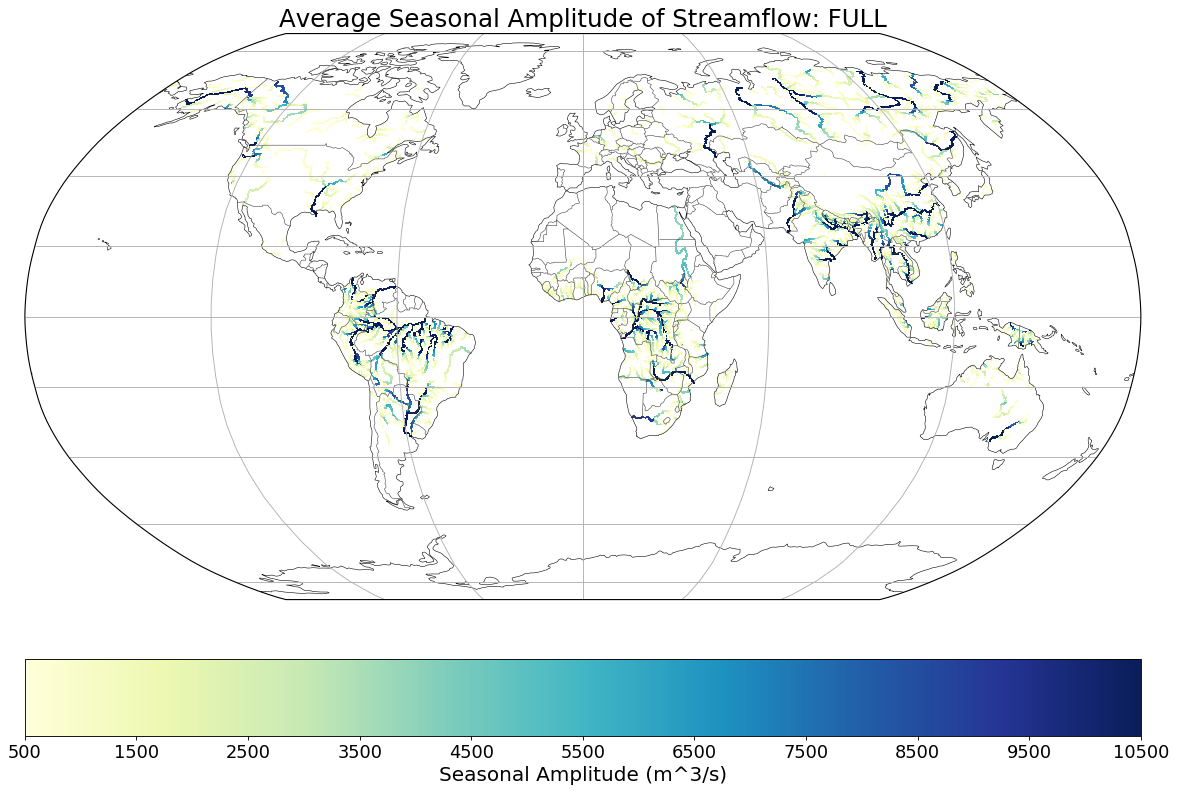

In [6]:
# ---- PLOT RAW SEASONAL AMPLITUDE ---- # 

cutoff = 500 #Threshold for minimum streamflow

#Blank places where seasonal amplitude is below threshold to pick out larger rivers on map
seasonalNew = seasonalFull
seasonalNew[np.where(seasonalFull<=cutoff)] = np.nan

#Define figure 
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()
bounds = np.arange(cutoff,10500+1)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

## --- Create Plot ---
contour_plot = ax.pcolormesh(lon,lat,seasonalNew,cmap='YlGnBu',norm=norm,vmin=cutoff,vmax=10500,transform=ccrs.PlateCarree())
#Colorbar 
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0+0.05, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Seasonal Amplitude (m^3/s)',fontsize=18)
cbar.ax.tick_params(labelsize=16)
tick_locator = ticker.LinearLocator(numticks=11)
cbar.locator = tick_locator
cbar.update_ticks()
#Other figure options 
ax.set_title('Average Seasonal Amplitude of Streamflow: FULL')
ax.title.set_fontsize(22)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

plt.show() 

#Save figure
#fig.savefig('/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/SeasonalAmplitude_CTRL.jpg',bbox_inches = 'tight')  #Save figure as jpg


In [7]:
# Compute percent change in seasonal amplitude from CTRL 

#Remove low streamflows first
seasonalCtrlNew = seasonalCtrl
seasonalCtrlNew[np.where(seasonalCtrl<=cutoff)] = np.nan

seasonalFullNew = seasonalFull
seasonalFullNew[np.where(seasonalFull<=cutoff)] = np.nan

seasonalPhysNew = seasonalPhys
seasonalPhysNew[np.where(seasonalPhys<=cutoff)] = np.nan

seasonalRadNew = seasonalRad
seasonalRadNew[np.where(seasonalRad<=cutoff)]   = np.nan

#Calculate percent change
pctFull = ((seasonalFullNew-seasonalCtrlNew)/seasonalCtrlNew) * 100
pctPhys = ((seasonalPhysNew-seasonalCtrlNew)/seasonalCtrlNew) * 100
pctRad  = ((seasonalRadNew-seasonalCtrlNew)/seasonalCtrlNew)  * 100

diffFull = seasonalFullNew-seasonalCtrlNew 
diffPhys = seasonalPhysNew-seasonalCtrlNew
diffRad  = seasonalRadNew-seasonalCtrlNew


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less_equal
  """
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less_equal
  # This is added back by InteractiveShellApp.init_path()
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less_equal
  


In [88]:
pctFull

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

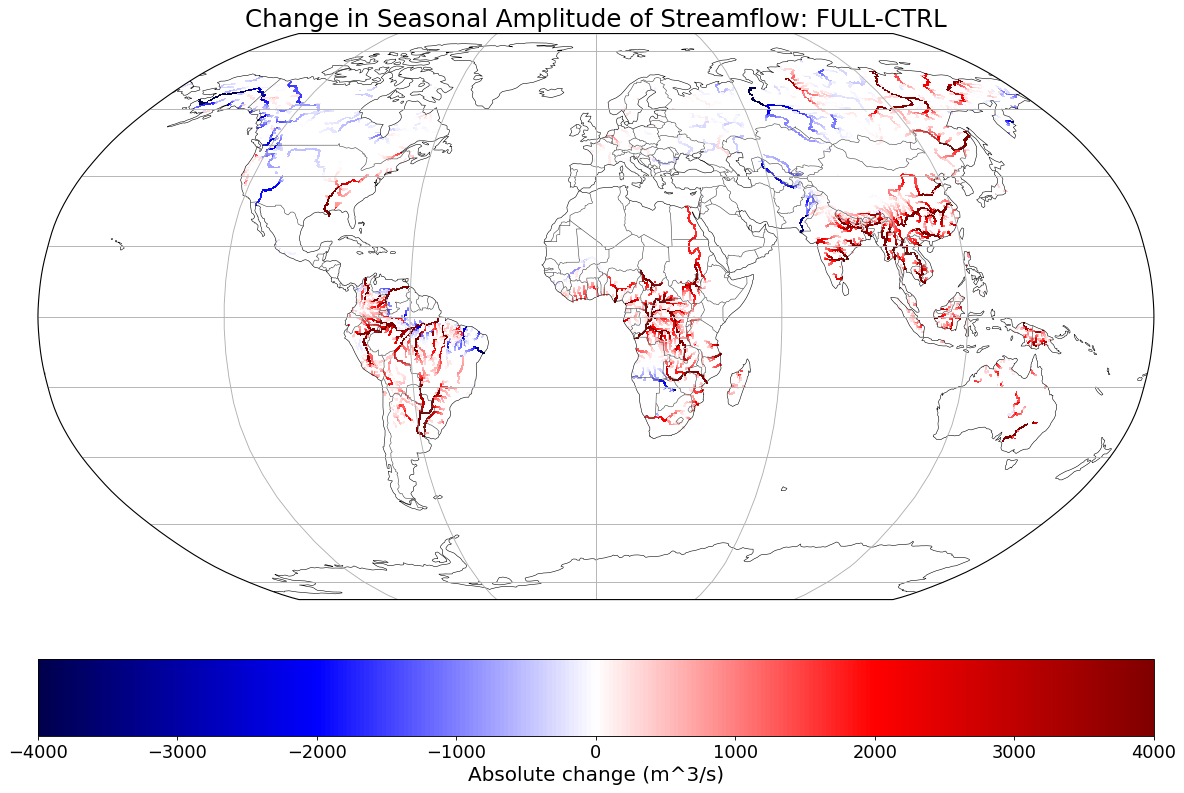

In [19]:
# Plot percent change in seasonal amplitude: FULL

#Define figure 
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()
#bounds = np.arange(cutoff,10500+1)
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

## --- Create Plot ---
#contour_plot = ax.pcolormesh(lon,lat,pctFull,cmap='seismic',vmin=-200,vmax=200,transform=ccrs.PlateCarree())
contour_plot = ax.pcolormesh(lon,lat,diffFull,cmap='seismic',vmin=-4000,vmax=4000,transform=ccrs.PlateCarree())

#Colorbar 
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0+0.05, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
#cbar.set_label('Percent change (%)',fontsize=18)
cbar.set_label('Absolute change (m^3/s)',fontsize=18)
cbar.ax.tick_params(labelsize=16)
#tick_locator = ticker.LinearLocator(numticks=11)
#cbar.locator = tick_locator
#cbar.update_ticks()
#Other figure options 
ax.set_title('Change in Seasonal Amplitude of Streamflow: FULL-CTRL')
ax.title.set_fontsize(22)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

plt.show() 

#Save figure
#fig.savefig('/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/SeasonalAmplitudeDiff_FULL.jpg',bbox_inches = 'tight')  #Save figure as jpg




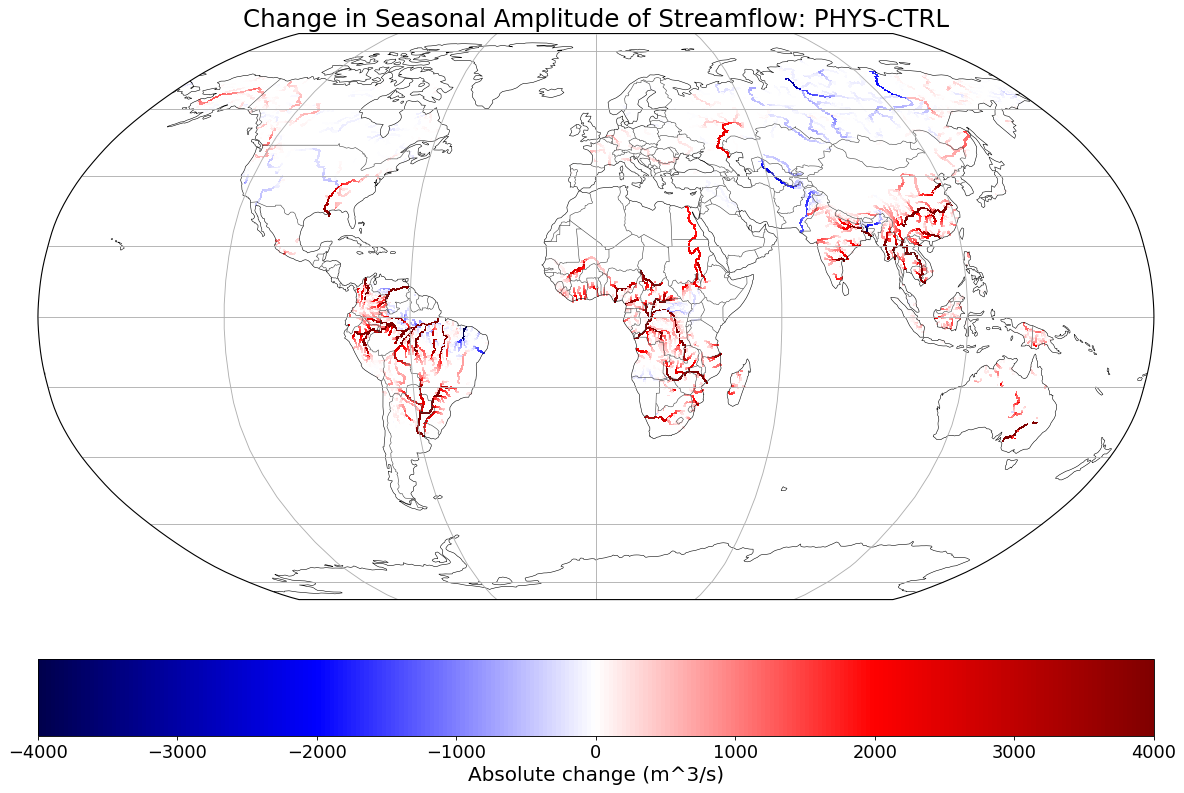

In [20]:
# Plot percent change in seasonal amplitude: PHYS

#Define figure 
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()
#bounds = np.arange(cutoff,10500+1)
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

## --- Create Plot ---
#contour_plot = ax.pcolormesh(lon,lat,pctPhys,cmap='seismic',vmin=-200,vmax=200,transform=ccrs.PlateCarree())
contour_plot = ax.pcolormesh(lon,lat,diffPhys,cmap='seismic',vmin=-4000,vmax=4000,transform=ccrs.PlateCarree())

#Colorbar 
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0+0.05, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
#cbar.set_label('Percent change (%)',fontsize=18)
cbar.set_label('Absolute change (m^3/s)',fontsize=18)
cbar.ax.tick_params(labelsize=16)
#tick_locator = ticker.LinearLocator(numticks=11)
#cbar.locator = tick_locator
#cbar.update_ticks()
#Other figure options 
ax.set_title('Change in Seasonal Amplitude of Streamflow: PHYS-CTRL')
ax.title.set_fontsize(22)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

plt.show() 

#Save figure
#fig.savefig('/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/SeasonalAmplitudeDiff_PHYS.jpg',bbox_inches = 'tight')  #Save figure as jpg



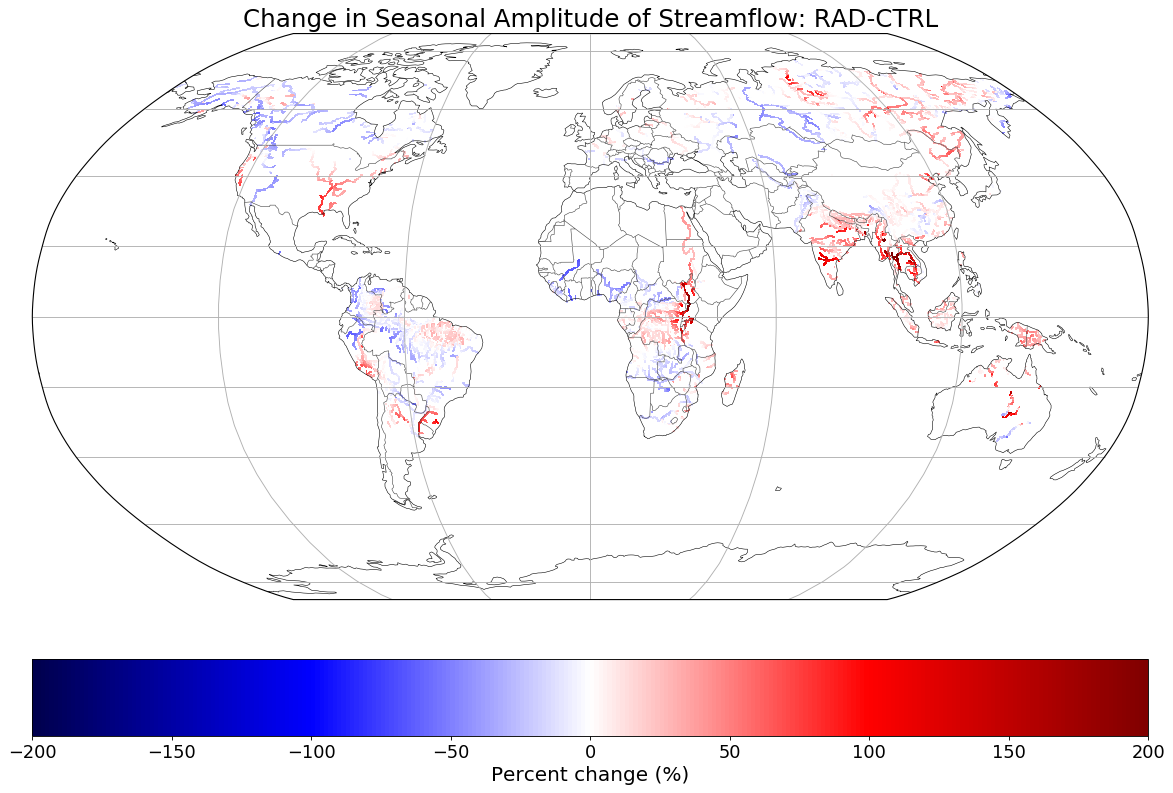

In [55]:
# Plot percent change in seasonal amplitude: RAD

#Define figure 
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()
#bounds = np.arange(cutoff,10500+1)
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

## --- Create Plot ---
contour_plot = ax.pcolormesh(lon,lat,pctRad,cmap='seismic',vmin=-200,vmax=200,transform=ccrs.PlateCarree())
#contour_plot = ax.pcolormesh(lon,lat,diffRad,cmap='seismic',vmin=-4000,vmax=4000,transform=ccrs.PlateCarree())

#Colorbar 
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0+0.05, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Percent change (%)',fontsize=18)
#cbar.set_label('Absolute change (m^3/s)',fontsize=18)
cbar.ax.tick_params(labelsize=16)
#tick_locator = ticker.LinearLocator(numticks=11)
#cbar.locator = tick_locator
#cbar.update_ticks()
#Other figure options 
ax.set_title('Change in Seasonal Amplitude of Streamflow: RAD-CTRL')
ax.title.set_fontsize(22)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

plt.show() 

#Save figure
#fig.savefig('/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/SeasonalAmplitudePctDiff_RAD.jpg',bbox_inches = 'tight')  #Save figure as jpg




### Do something similar to above, but look at the percent change (and raw background) of just *low* flows and *high* flows

/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less_equal
  import sys


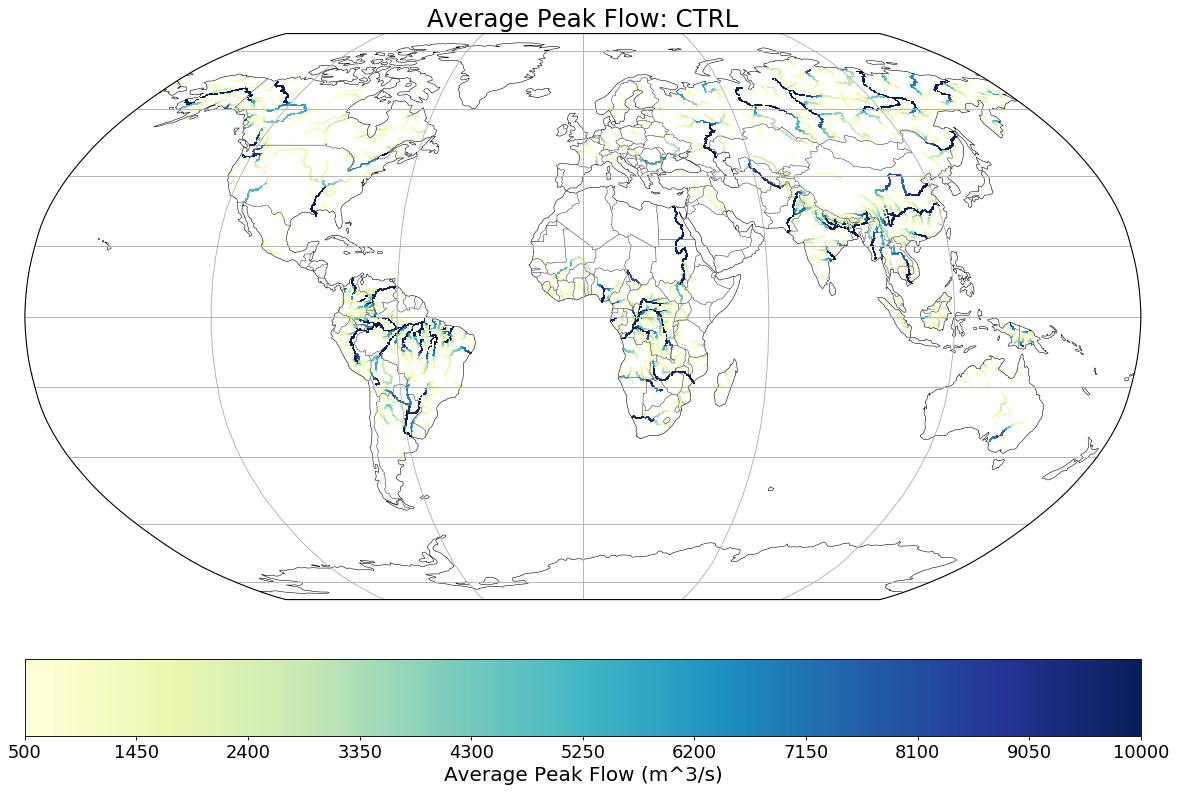

In [8]:
# ---- PLOT RAW AVERAGE LOW FLOWS ---- # 
 
cutoff = 500 #Threshold for minimum streamflow

#Blank places where seasonal amplitude is below threshold to pick out larger rivers on map
maxNew = avgMaxCtrl
maxNew[np.where(avgMaxCtrl<=cutoff)] = np.nan

#Define figure 
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()
bounds = np.arange(cutoff,10000+1)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

## --- Create Plot ---
#contour_plot = ax.pcolormesh(lon,lat,avgMinCtrl,cmap='YlGnBu',vmin=cutoff,transform=ccrs.PlateCarree())
contour_plot = ax.pcolormesh(lon,lat,maxNew,cmap='YlGnBu',norm=norm,vmin=cutoff,vmax=10000,transform=ccrs.PlateCarree())
#Colorbar 
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0+0.05, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Average Peak Flow (m^3/s)',fontsize=18)
cbar.ax.tick_params(labelsize=16)
tick_locator = ticker.LinearLocator(numticks=11)
cbar.locator = tick_locator
cbar.update_ticks()
#Other figure options 
ax.set_title('Average Peak Flow: CTRL')
ax.title.set_fontsize(22)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

plt.show() 

In [9]:
#To isolate actual rivers, choose those where the MAXIMUM flow is at least _500_ m3/s 
#     (in CTRL), and for MINIMUM flow, where the flow is greater than _50_ m3/s (in CTRL)
cutoffMax = 500
cutoffMin = 50

maxCtrlNew = avgMaxCtrl
minCtrlNew = avgMinCtrl
maxCtrlNew[np.where(avgMaxCtrl<=cutoffMax)] = np.nan
minCtrlNew[np.where(avgMinCtrl<=cutoffMin)] = np.nan

maxFullNew = avgMaxFull
minFullNew = avgMinFull
maxFullNew[np.where(avgMaxCtrl<=cutoffMax)] = np.nan
minFullNew[np.where(avgMinCtrl<=cutoffMin)] = np.nan

maxPhysNew = avgMaxPhys
minPhysNew = avgMinPhys
maxPhysNew[np.where(avgMaxCtrl<=cutoffMax)] = np.nan
minPhysNew[np.where(avgMinCtrl<=cutoffMin)] = np.nan

maxRadNew = avgMaxRad
minRadNew = avgMinRad
maxRadNew[np.where(avgMaxCtrl<=cutoffMax)]   = np.nan
minRadNew[np.where(avgMinCtrl<=cutoffMin)]   = np.nan

#Define percent change in average min and max flows 
diffMinFull = ((minFullNew-minCtrlNew)/minCtrlNew)*100
diffMinPhys = ((minPhysNew-minCtrlNew)/minCtrlNew)*100
diffMinRad  = ((minRadNew-minCtrlNew)/minCtrlNew)*100

diffMaxFull = ((maxFullNew-maxCtrlNew)/maxCtrlNew)*100
diffMaxPhys = ((maxPhysNew-maxCtrlNew)/maxCtrlNew)*100
diffMaxRad  = ((maxRadNew-maxCtrlNew)/maxCtrlNew)*100


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less_equal
  del sys.path[0]
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less_equal
  
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less_equal
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less_equal
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less_equal
/hom

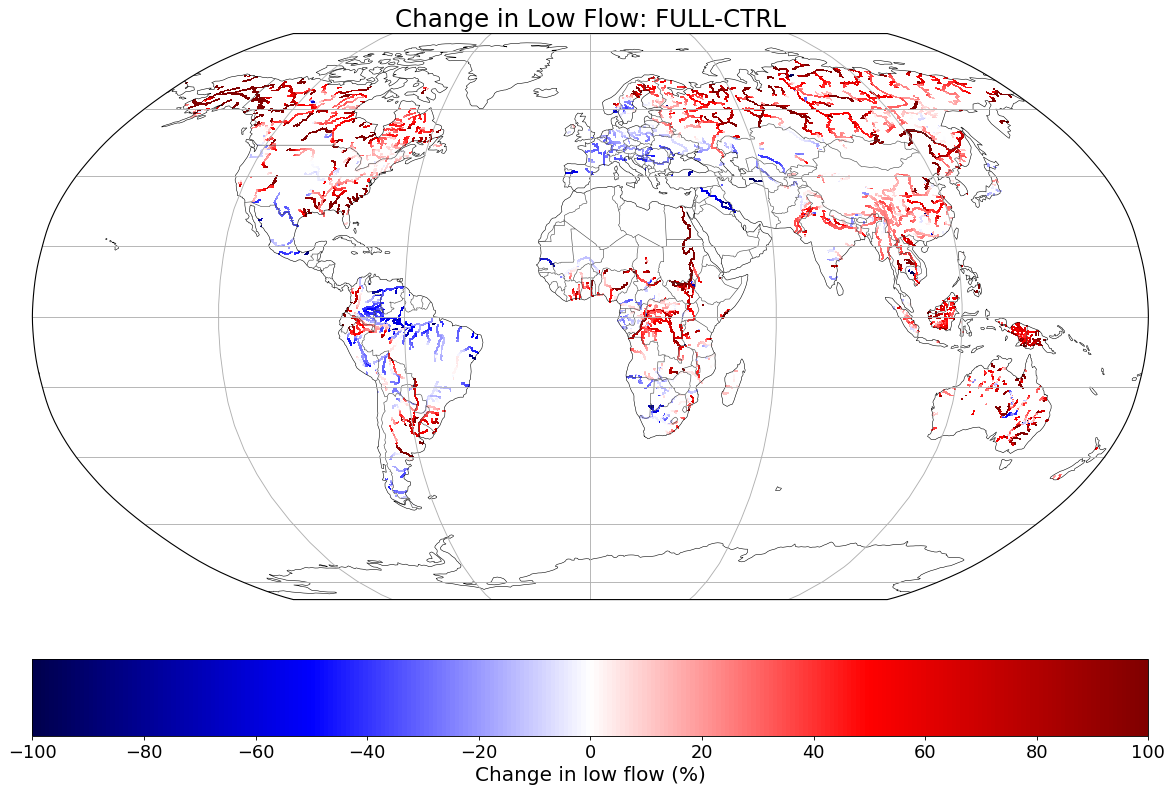

In [16]:
#Define figure 
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

## --- Create Plot ---
contour_plot = ax.pcolormesh(lon,lat,diffMinFull,cmap='seismic',vmin=-100,vmax=100,transform=ccrs.PlateCarree())
#Colorbar 
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0+0.05, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Change in low flow (%)',fontsize=18)
cbar.ax.tick_params(labelsize=16)
tick_locator = ticker.LinearLocator(numticks=11)
cbar.locator = tick_locator
cbar.update_ticks()
#Other figure options 
ax.set_title('Change in Low Flow: FULL-CTRL')
ax.title.set_fontsize(22)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

plt.show() 

#Save figure
#fig.savefig('/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/LowFlowDiff_FULL.jpg',bbox_inches = 'tight')  #Save figure as jpg



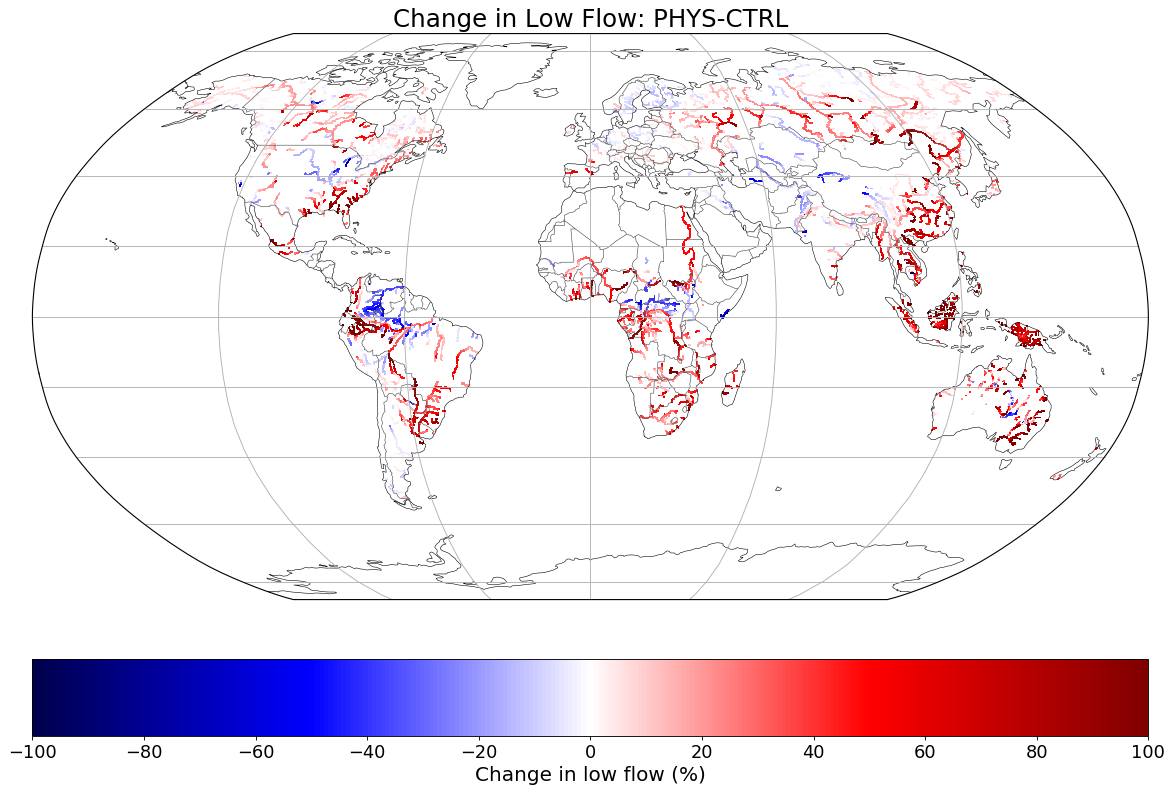

In [17]:
#Define figure 
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

## --- Create Plot ---
contour_plot = ax.pcolormesh(lon,lat,diffMinPhys,cmap='seismic',vmin=-100,vmax=100,transform=ccrs.PlateCarree())
#Colorbar 
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0+0.05, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Change in low flow (%)',fontsize=18)
cbar.ax.tick_params(labelsize=16)
tick_locator = ticker.LinearLocator(numticks=11)
cbar.locator = tick_locator
cbar.update_ticks()
#Other figure options 
ax.set_title('Change in Low Flow: PHYS-CTRL')
ax.title.set_fontsize(22)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

plt.show() 

#Save figure
#fig.savefig('/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/LowFlowDiff_PHYS.jpg',bbox_inches = 'tight')  #Save figure as jpg



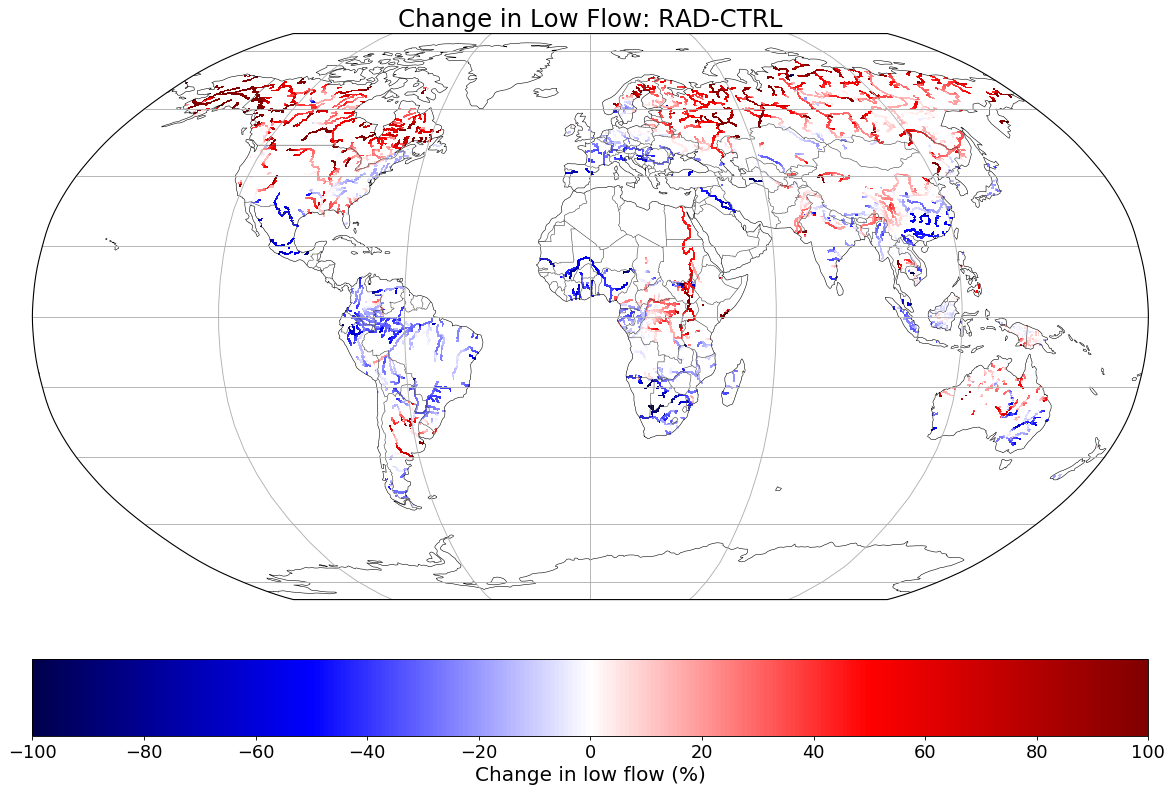

In [18]:
#Define figure 
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

## --- Create Plot ---
contour_plot = ax.pcolormesh(lon,lat,diffMinRad,cmap='seismic',vmin=-100,vmax=100,transform=ccrs.PlateCarree())
#Colorbar 
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0+0.05, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Change in low flow (%)',fontsize=18)
cbar.ax.tick_params(labelsize=16)
tick_locator = ticker.LinearLocator(numticks=11)
cbar.locator = tick_locator
cbar.update_ticks()
#Other figure options 
ax.set_title('Change in Low Flow: RAD-CTRL')
ax.title.set_fontsize(22)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

plt.show() 

#Save figure
#fig.savefig('/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/LowFlowDiff_Rad.jpg',bbox_inches = 'tight')  #Save figure as jpg



/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less_equal
  import sys
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less_equal
  del sys.path[0]
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less_equal
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less_equal
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less_equal

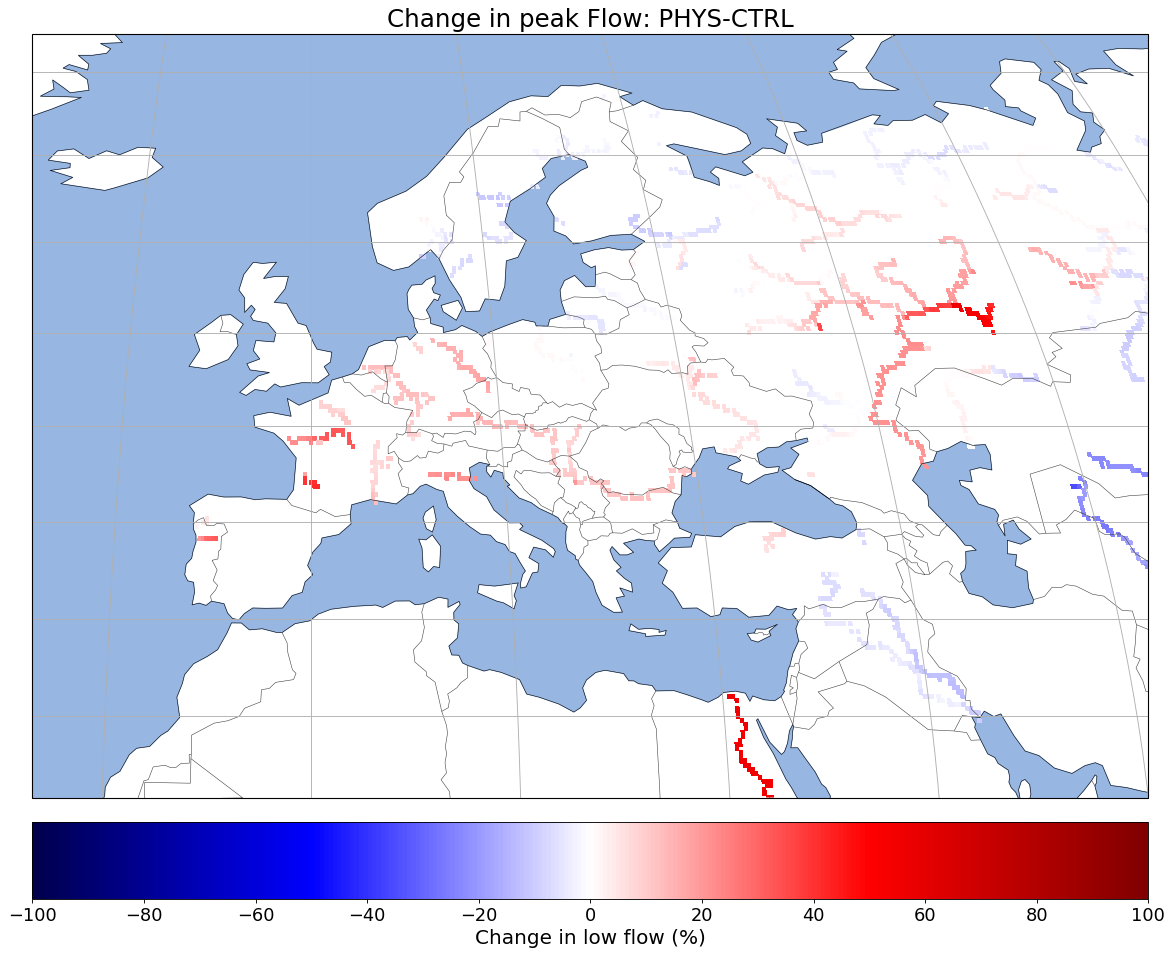

In [79]:
###### ------  FIGURE FOR LOW/PEAK FLOW IN WESTERN EUROPE ONLY -------- #######

cutoff = 50

europeMaxCtrl = avgMaxCtrl
europeMinCtrl = avgMinCtrl
europeMaxCtrl[np.where(avgMaxCtrl<=cutoff)] = np.nan
europeMinCtrl[np.where(avgMinCtrl<=cutoff)] = np.nan

europeMaxFull = avgMaxFull
europeMinFull = avgMinFull
europeMaxFull[np.where(avgMaxCtrl<=cutoff)] = np.nan
europeMinFull[np.where(avgMinCtrl<=cutoff)] = np.nan

europeMaxPhys = avgMaxPhys
europeMinPhys = avgMinPhys
europeMaxPhys[np.where(avgMaxCtrl<=cutoff)] = np.nan
europeMinPhys[np.where(avgMinCtrl<=cutoff)] = np.nan

europeMaxRad  = avgMaxRad
europeMinRad  = avgMinRad
europeMaxRad[np.where(avgMaxCtrl<=cutoff)] = np.nan
europeMinRad[np.where(avgMinCtrl<=cutoff)] = np.nan

pctMinFull = ((europeMinFull-europeMinCtrl)/europeMinCtrl)*100
pctMaxFull = ((europeMaxFull-europeMaxCtrl)/europeMaxCtrl)*100
pctMinPhys = ((europeMinPhys-europeMinCtrl)/europeMinCtrl)*100
pctMaxPhys = ((europeMaxPhys-europeMaxCtrl)/europeMaxCtrl)*100
pctMinRad  = ((europeMinRad-europeMinCtrl)/europeMinCtrl)*100
pctMaxRad  = ((europeMaxRad-europeMaxCtrl)/europeMaxCtrl)*100

#Define figure 
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_extent([-20,60,25,75], crs=ccrs.PlateCarree())

## --- Create Plot ---
contour_plot = ax.pcolormesh(lon,lat,pctMaxPhys,cmap='seismic',vmin=-100,vmax=100,transform=ccrs.PlateCarree())
#Colorbar 
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Change in low flow (%)',fontsize=18)
cbar.ax.tick_params(labelsize=16)
tick_locator = ticker.LinearLocator(numticks=11)
cbar.locator = tick_locator
cbar.update_ticks()
#Other figure options 
ax.set_title('Change in peak Flow: PHYS-CTRL')
ax.title.set_fontsize(22)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax.add_feature(cfeature.OCEAN)

plt.show() 



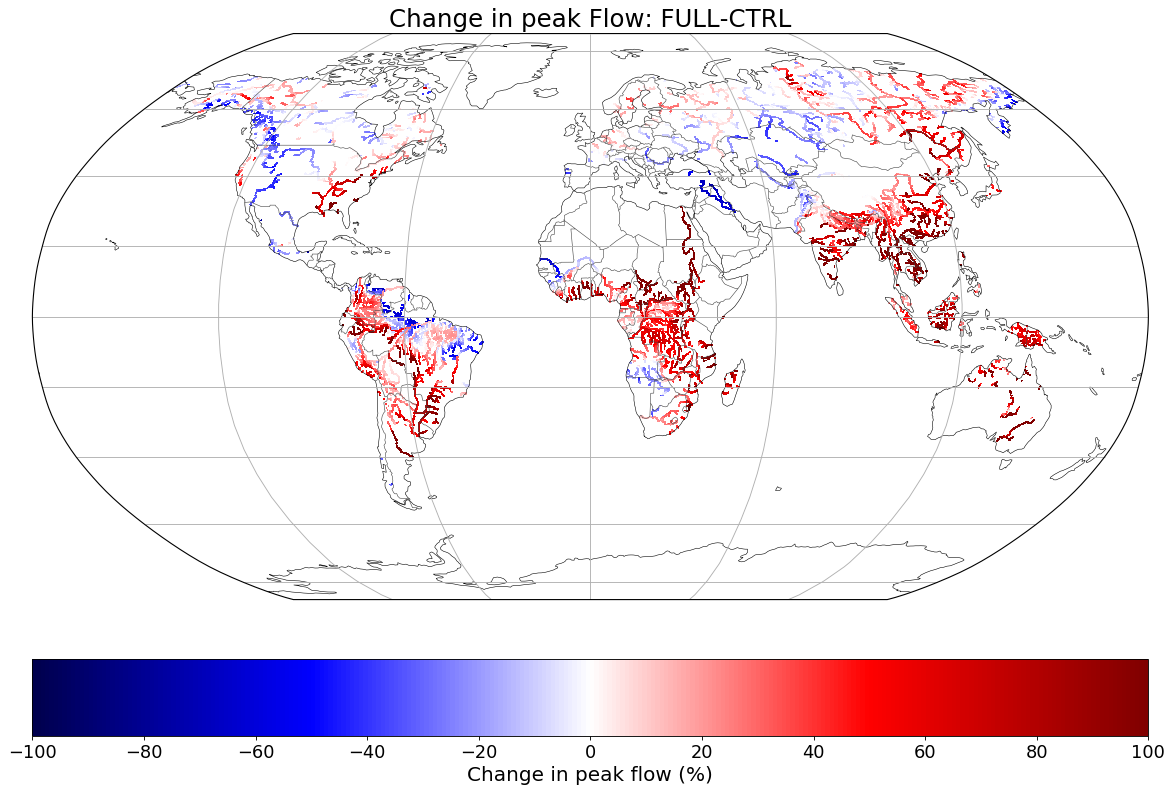

In [37]:
#Define figure 
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

## --- Create Plot ---
contour_plot = ax.pcolormesh(lon,lat,diffMaxFull,cmap='seismic',vmin=-100,vmax=100,transform=ccrs.PlateCarree())
#Colorbar 
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0+0.05, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Change in peak flow (%)',fontsize=18)
cbar.ax.tick_params(labelsize=16)
tick_locator = ticker.LinearLocator(numticks=11)
cbar.locator = tick_locator
cbar.update_ticks()
#Other figure options 
ax.set_title('Change in peak Flow: FULL-CTRL')
ax.title.set_fontsize(22)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

plt.show() 

#Save figure
#fig.savefig('/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/PeakFlowDiff_FULL.jpg',bbox_inches = 'tight')  #Save figure as jpg




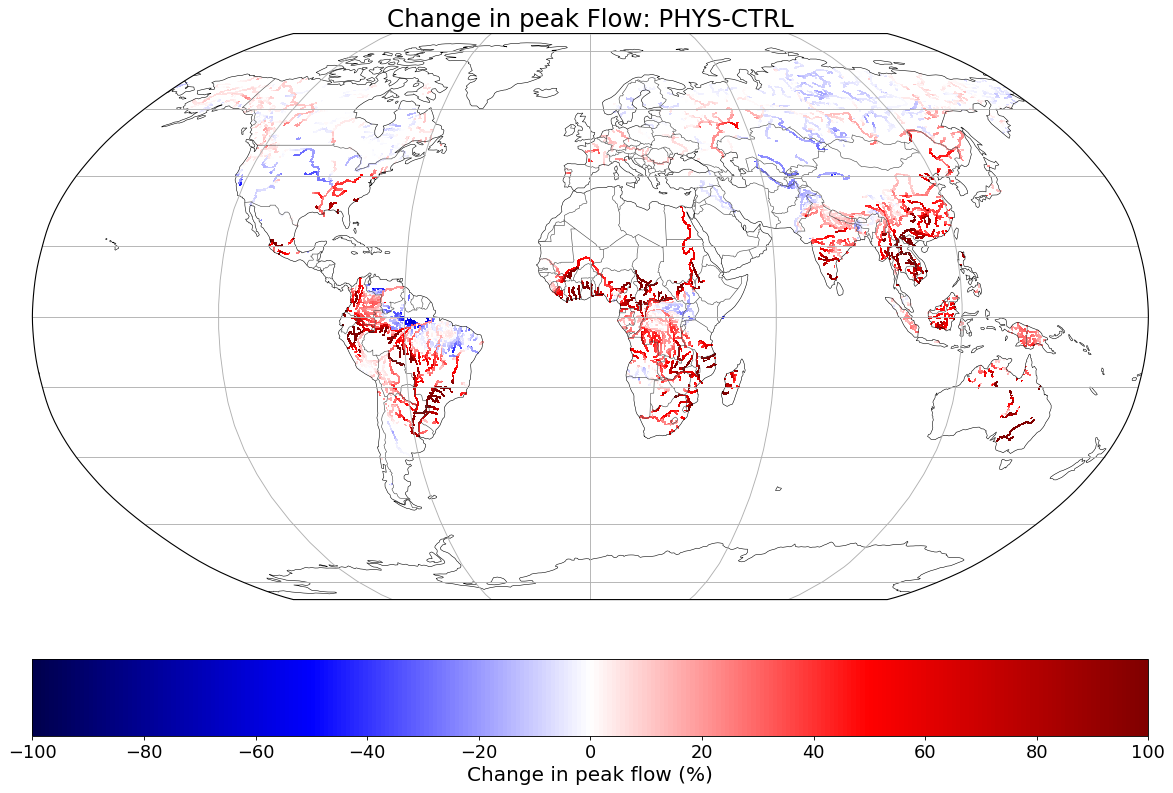

In [38]:
#Define figure 
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

## --- Create Plot ---
contour_plot = ax.pcolormesh(lon,lat,diffMaxPhys,cmap='seismic',vmin=-100,vmax=100,transform=ccrs.PlateCarree())
#Colorbar 
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0+0.05, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Change in peak flow (%)',fontsize=18)
cbar.ax.tick_params(labelsize=16)
tick_locator = ticker.LinearLocator(numticks=11)
cbar.locator = tick_locator
cbar.update_ticks()
#Other figure options 
ax.set_title('Change in peak Flow: PHYS-CTRL')
ax.title.set_fontsize(22)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

plt.show() 

#Save figure
#fig.savefig('/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/PeakFlowDiff_PHYS.jpg',bbox_inches = 'tight')  #Save figure as jpg



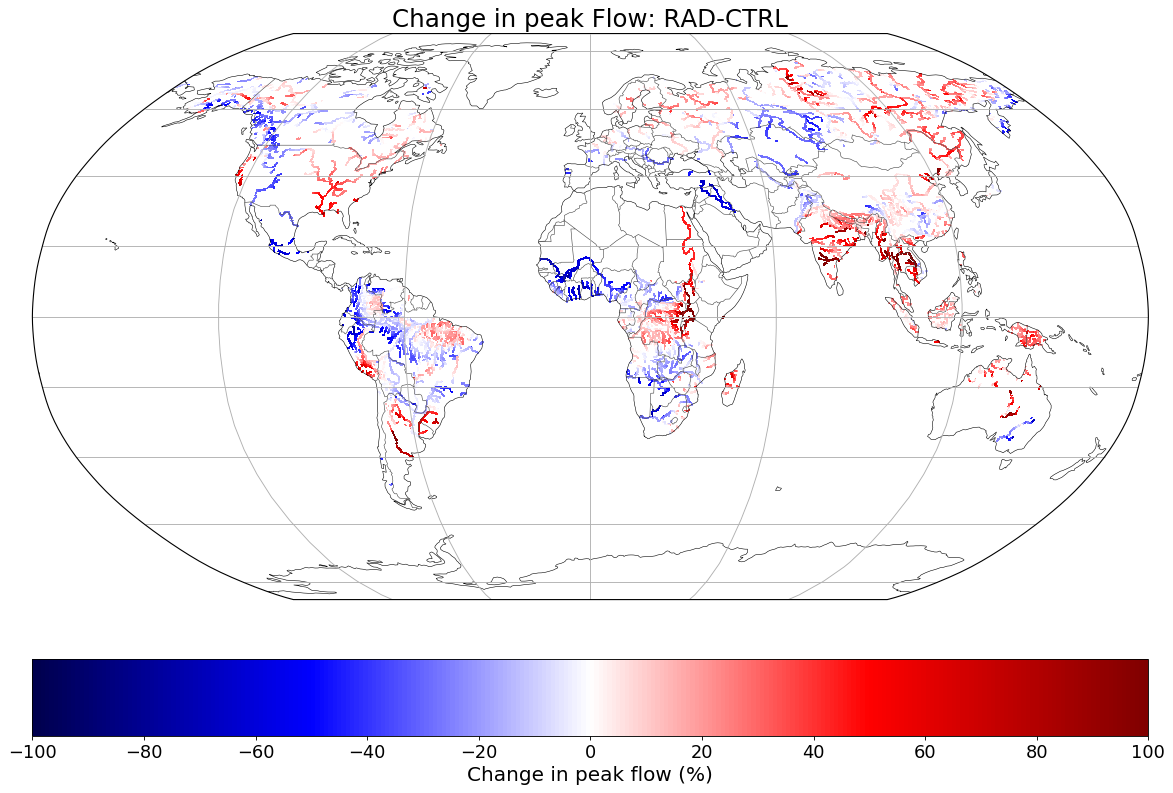

In [39]:
#Define figure 
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

## --- Create Plot ---
contour_plot = ax.pcolormesh(lon,lat,diffMaxRad,cmap='seismic',vmin=-100,vmax=100,transform=ccrs.PlateCarree())
#Colorbar 
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0+0.05, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Change in peak flow (%)',fontsize=18)
cbar.ax.tick_params(labelsize=16)
tick_locator = ticker.LinearLocator(numticks=11)
cbar.locator = tick_locator
cbar.update_ticks()
#Other figure options 
ax.set_title('Change in peak Flow: RAD-CTRL')
ax.title.set_fontsize(22)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

plt.show() 

#Save figure
#fig.savefig('/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/PeakFlowDiff_RAD.jpg',bbox_inches = 'tight')  #Save figure as jpg




## What does the change in just average flow look like? 
Can we identify locations where the change in range or high/low flows is DIFFERENT than what the mean change would predict?

In [10]:
meanCtrl = np.nanmean(np.nanmean(avgCtrl,axis=0),axis=0)
meanFull = np.nanmean(np.nanmean(avgFull,axis=0),axis=0)
meanPhys = np.nanmean(np.nanmean(avgPhys,axis=0),axis=0)
meanRad  = np.nanmean(np.nanmean(avgRad,axis=0),axis=0)


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less_equal
  import sys


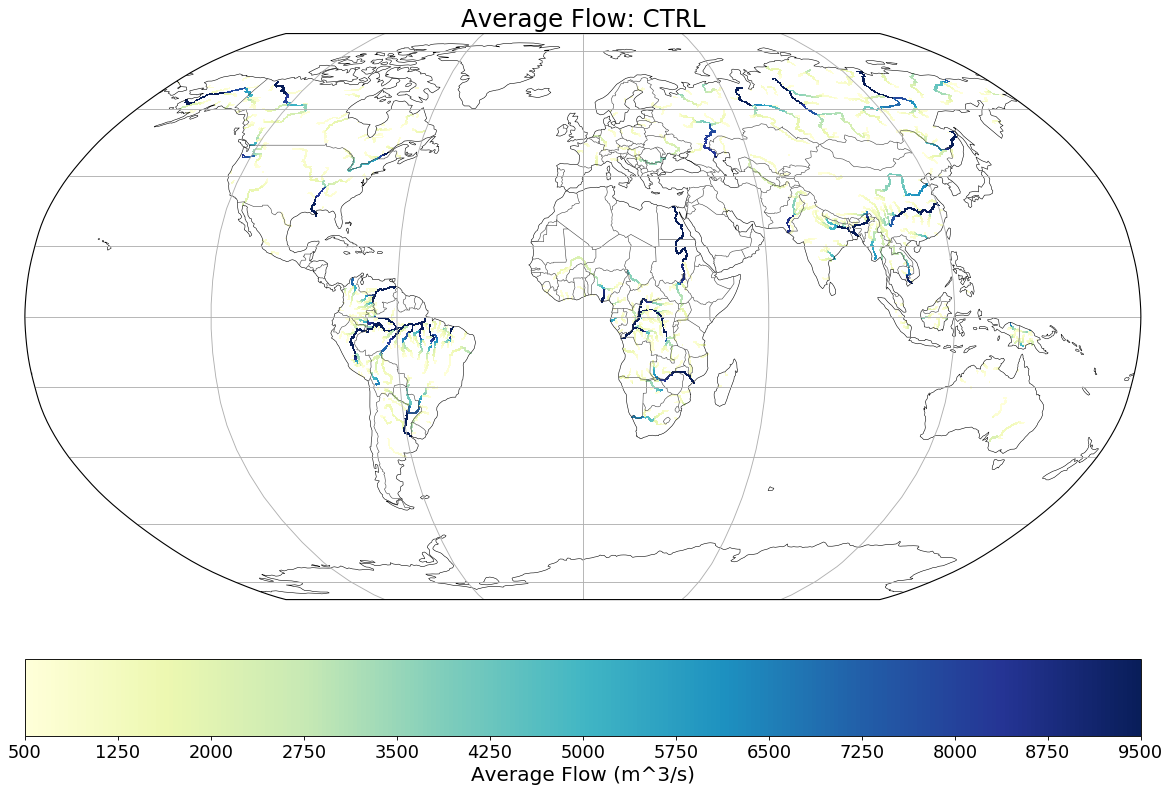

In [11]:
# ---- PLOT RAW AVERAGE LOW FLOWS ---- # 
 
cutoff = 500 #Threshold for minimum streamflow

#Blank places where seasonal amplitude is below threshold to pick out larger rivers on map
avgNew = meanCtrl
avgNew[np.where(meanCtrl<=cutoff)] = np.nan

#Define figure 
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()
bounds = np.arange(cutoff,9500+1)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

## --- Create Plot ---
contour_plot = ax.pcolormesh(lon,lat,avgNew,cmap='YlGnBu',norm=norm,vmin=cutoff,vmax=9500,transform=ccrs.PlateCarree())
#Colorbar 
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0+0.05, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Average Flow (m^3/s)',fontsize=18)
cbar.ax.tick_params(labelsize=16)
tick_locator = ticker.LinearLocator(numticks=13)
cbar.locator = tick_locator
cbar.update_ticks()
#Other figure options 
ax.set_title('Average Flow: CTRL')
ax.title.set_fontsize(22)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

plt.show() 

In [12]:
#Use a cutoff to pick out only actual rivers
#cutoffMax = 50
cutoffMax = 500 

avgCtrlNew = meanCtrl
avgCtrlNew[np.where(meanCtrl<=cutoffMax)] = np.nan
avgFullNew = meanFull
avgFullNew[np.where(meanFull<=cutoffMax)] = np.nan
avgPhysNew = meanPhys
avgPhysNew[np.where(meanPhys<=cutoffMax)] = np.nan
avgRadNew  = meanRad 
avgRadNew[np.where(meanRad<=cutoffMax)]   = np.nan

#Compute percent change and raw differences 
diffFull = avgFullNew - avgCtrlNew 
diffPhys = avgPhysNew - avgCtrlNew
diffRad  = avgRadNew  - avgCtrlNew

pctDiffFull = (diffFull/avgCtrlNew)*100
pctDiffPhys = (diffPhys/avgCtrlNew)*100
pctDiffRad  = (diffRad/avgCtrlNew)*100


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less_equal
  # Remove the CWD from sys.path while we load stuff.
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


* Begin plotting

In [67]:
print(np.nanmin(np.nanmin(avgCtrlNew)))

50.011016253630316


In [ ]:
# ---- CHANGE IN WESTERN EUROPE ONLY ---- # 
 
#Define figure 
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
#ax.set_global()
ax.set_extent([-20,60,25,75], crs=ccrs.PlateCarree())

## --- Create Plot ---
contour_plot = ax.pcolormesh(lon,lat,pctDiffFull,cmap='seismic',vmin=-100,vmax=100,transform=ccrs.PlateCarree())
#Colorbar 
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0, ax_position.width, 0.06])   #For zoomed in version
#cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0+0.05, ax_position.width, 0.06])

cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Percent change (%)',fontsize=18)
cbar.ax.tick_params(labelsize=16)
#Other figure options 
ax.set_title('Change in Average Flow: FULL-CTRL')
ax.title.set_fontsize(22)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax.add_feature(cfeature.OCEAN)

plt.show() 

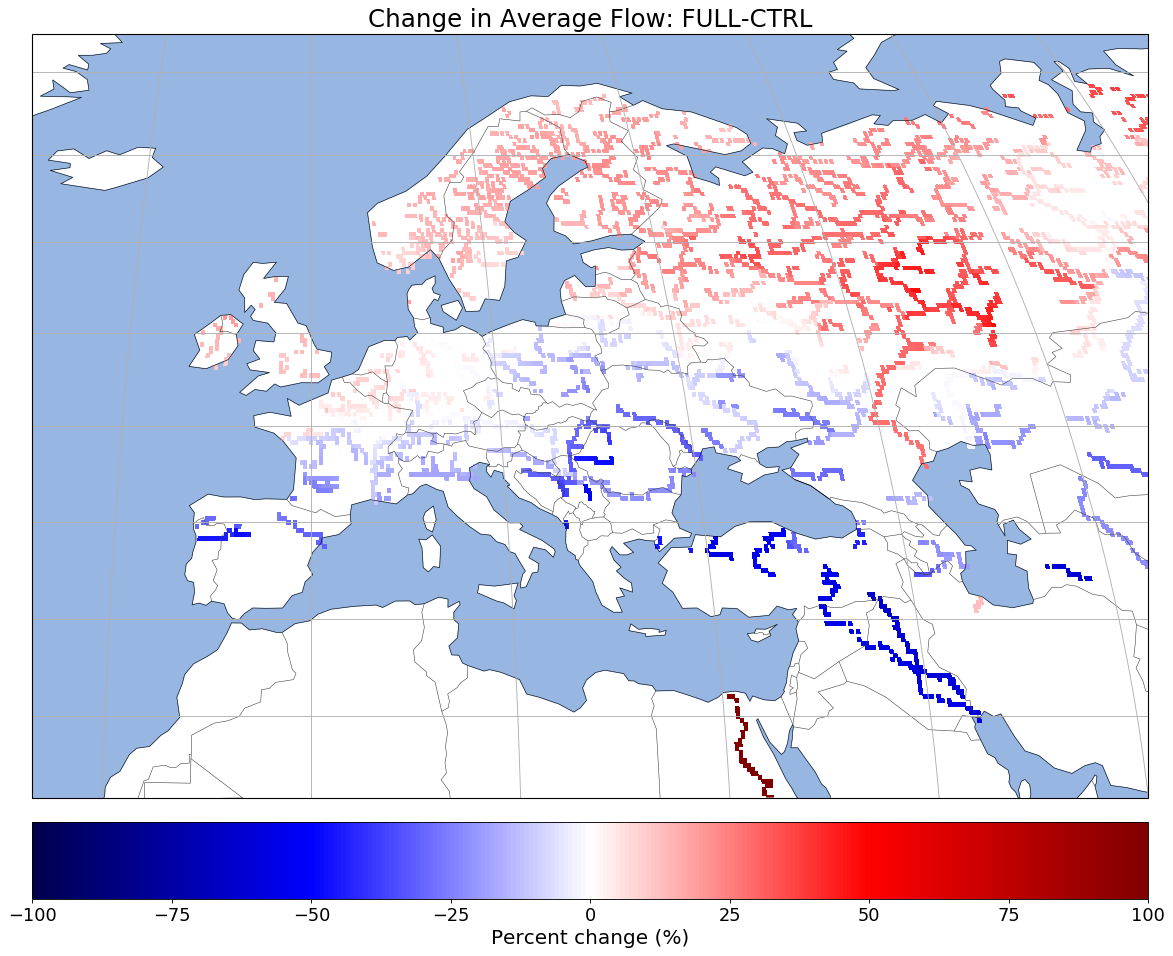

In [68]:
# ---- PLOT %-Change in mean flow ---- # 
 
#Define figure 
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

## --- Create Plot ---
contour_plot = ax.pcolormesh(lon,lat,pctDiffFull,cmap='seismic',vmin=-100,vmax=10,transform=ccrs.PlateCarree())
#Colorbar 
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0+0.05, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Percent change (%)',fontsize=18)
cbar.ax.tick_params(labelsize=16)
#Other figure options 
ax.set_title('Change in Average Flow: FULL-CTRL')
ax.title.set_fontsize(22)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

plt.show() 

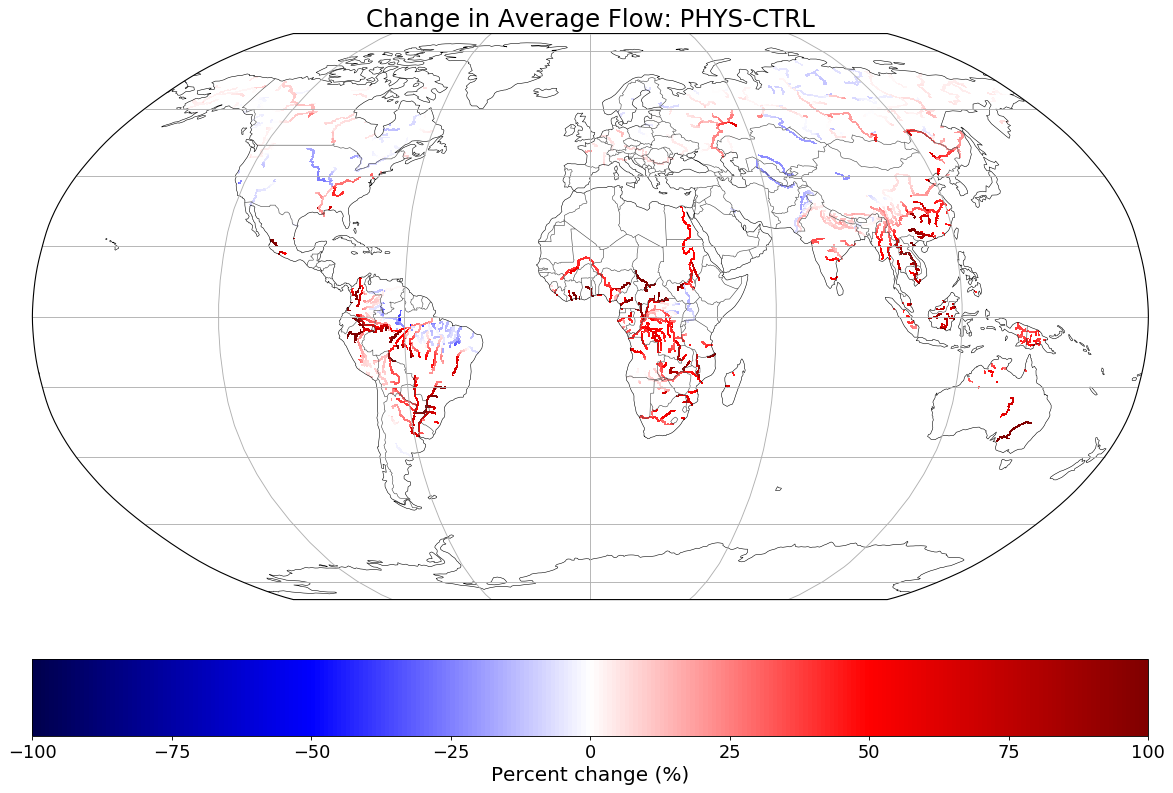

In [24]:
# ---- PLOT %-Change in mean flow ---- # 
 
#Define figure 
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

## --- Create Plot ---
contour_plot = ax.pcolormesh(lon,lat,pctDiffPhys,cmap='seismic',vmin=-100,vmax=100,transform=ccrs.PlateCarree())
#Colorbar 
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0+0.05, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Percent change (%)',fontsize=18)
cbar.ax.tick_params(labelsize=16)
#Other figure options 
ax.set_title('Change in Average Flow: PHYS-CTRL')
ax.title.set_fontsize(22)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

plt.show() 

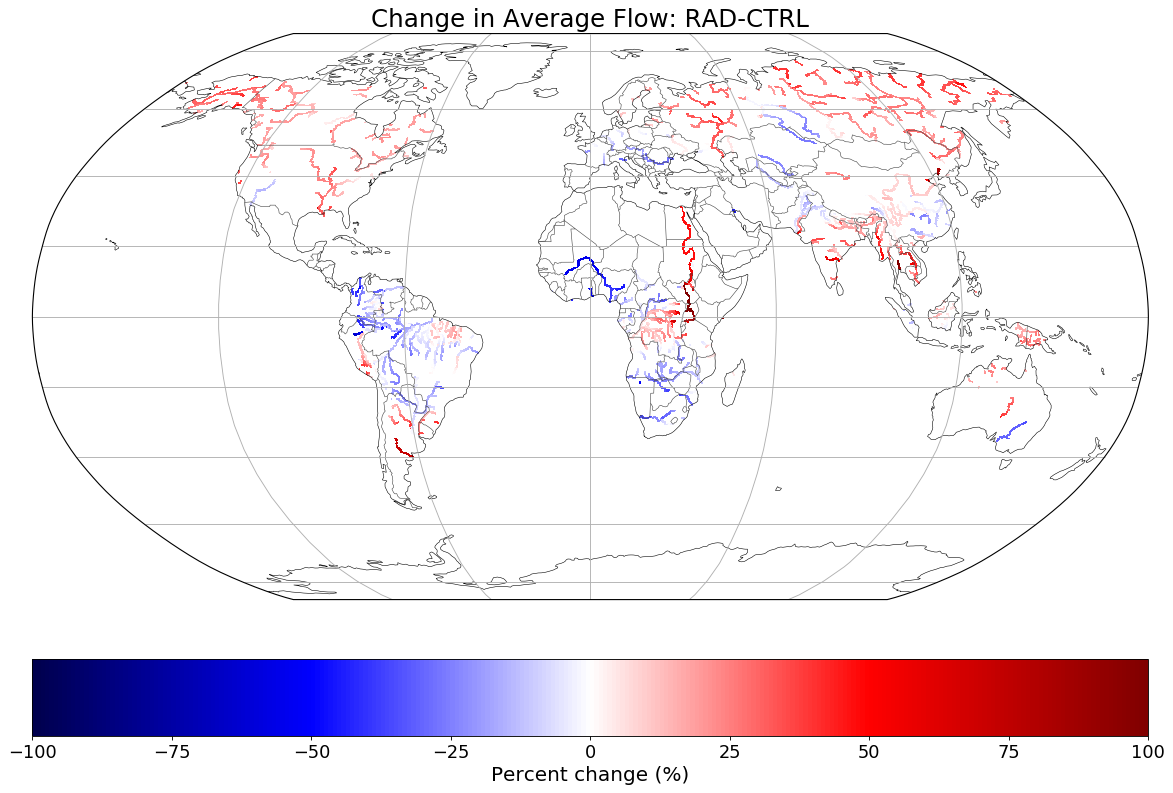

In [33]:
# ---- PLOT %-Change in mean flow ---- # 
 
#Define figure 
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

## --- Create Plot ---
contour_plot = ax.pcolormesh(lon,lat,pctDiffRad,cmap='seismic',vmin=-100,vmax=100,transform=ccrs.PlateCarree())
#Colorbar 
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0+0.05, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Percent change (%)',fontsize=18)
cbar.ax.tick_params(labelsize=16)
#Other figure options 
ax.set_title('Change in Average Flow: RAD-CTRL')
ax.title.set_fontsize(22)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

plt.show() 

## Similar to above, make map of %-change in the raw annual max RUNOFF (prior to downscaling)

In [21]:
# Read in monthly runoff 
fCtrl_run = xr.open_dataset(('/gdata/pritchard2/mdfowler/Flooding-physiology/rawRunoff/cesm1_0_6.1850_prei.1deg.001.clm2.MonthlyRunoff.nc'),decode_times=False)
fFull_run = xr.open_dataset(('/gdata/pritchard2/mdfowler/Flooding-physiology/rawRunoff/cesm1_0_6.1850_4xco2_fulgb.1deg.002.clm2.MonthlyRunoff.nc'),decode_times=False)
fPhys_run = xr.open_dataset(('/gdata/pritchard2/mdfowler/Flooding-physiology/rawRunoff/cesm1_0_6.1850_4xco2_fixgb.1deg.001.clm2.MonthlyRunoff.nc'),decode_times=False)
fRad_run  = xr.open_dataset(('/gdata/pritchard2/mdfowler/Flooding-physiology/rawRunoff/cesm1_0_6.1850_4xco2_fdbgb.1deg.002.clm2.MonthlyRunoff.nc'),decode_times=False)

ctrlRunoff = fCtrl_run.QRUNOFF     #[mm/s]
fullRunoff = fFull_run.QRUNOFF
physRunoff = fPhys_run.QRUNOFF
radRunoff  = fRad_run.QRUNOFF

#CESM lat and lon
cesmLon = fCtrl_run.lon.values
cesmLat = fCtrl_run.lat.values


In [20]:
# Split into yearly arrays -- [30, 12, 192, 288]
annRunoffCtrl = np.split(ctrlRunoff.values,30,axis=0)
annRunoffFull = np.split(fullRunoff.values,30,axis=0)
annRunoffPhys = np.split(physRunoff.values,30,axis=0)
annRunoffRad  = np.split(radRunoff.values,30,axis=0)

#Pick out maximum month for each location 
maxRunoffCtrl     = np.max(annRunoffCtrl, axis=1)
avgMaxRunoffCtrl  = np.nanmean(maxRunoffCtrl,axis=0)

maxRunoffFull     = np.max(annRunoffFull, axis=1)
avgMaxRunoffFull  = np.nanmean(maxRunoffFull,axis=0)

maxRunoffPhys     = np.max(annRunoffPhys, axis=1)
avgMaxRunoffPhys  = np.nanmean(maxRunoffPhys,axis=0)

maxRunoffRad      = np.max(annRunoffRad, axis=1)
avgMaxRunoffRad   = np.nanmean(maxRunoffRad,axis=0) 

# Percent differences
pctRunoffFull = ((avgMaxRunoffFull-avgMaxRunoffCtrl)/avgMaxRunoffCtrl)*100
pctRunoffPhys = ((avgMaxRunoffPhys-avgMaxRunoffCtrl)/avgMaxRunoffCtrl)*100
pctRunoffRad  = ((avgMaxRunoffRad-avgMaxRunoffCtrl)/avgMaxRunoffCtrl)*100


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


In [19]:
np.shape(avgMaxRunoffRad)

(192, 288)

In [22]:
# Apply river network mask -- isolate only rivers where annual average streamflow (in CTRL) >= 500 mm/s
# cutoffMax = 500 

# avgCtrlNew_runoff = avgMaxRunoffCtrl
# avgCtrlNew_runoff[np.where(avgMaxCtrl<=cutoffMax)] = np.nan

# avgFullNew_runoff = avgMaxRunoffFull
# avgFullNew_runoff[np.where(avgMaxCtrl<=cutoffMax)] = np.nan

# avgPhysNew_runoff = avgMaxRunoffPhys
# avgPhysNew_runoff[np.where(avgMaxCtrl<=cutoffMax)] = np.nan

# avgRadNew_runoff = avgMaxRunoffRad
# avgRadNew_runoff[np.where(avgMaxCtrl<=cutoffMax)] = np.nan

# #Compute percent change and raw differences 
# diffRunoffFull = avgFullNew_runoff - avgCtrlNew_runoff 
# diffRunoffPhys = avgPhysNew_runoff - avgCtrlNew_runoff
# diffRunoffRad  = avgRadNew_runoff  - avgCtrlNew_runoff

# pctDiffRunoffFull = (diffRunoffFull/avgCtrlNew_runoff)*100
# pctDiffRunoffPhys = (diffRunoffPhys/avgCtrlNew_runoff)*100
# pctDiffRunoffRad  = (diffRunoffRad/avgCtrlNew_runoff)*100


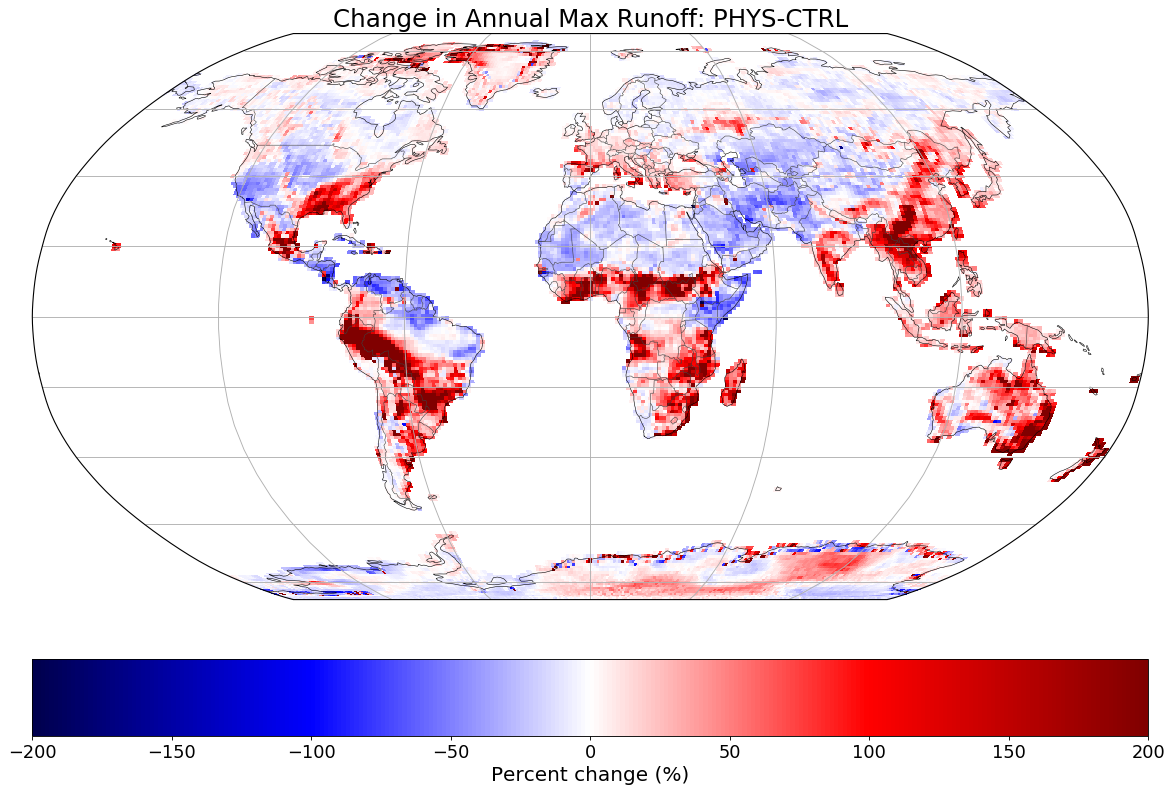

In [28]:
# ---- PLOT %-Change in annual max runoff flow ---- # 
 
#-----
# Define cyclic percent diff 
var_cyclicPhys, lon_cyclic = cartopy.util.add_cyclic_point(pctRunoffPhys, cesmLon) #Adds one more strip of data to the file to be cyclic
#-----

#-----
#Fix for when pcolor mesh leads to data falling off the continent 
#   Code from Baird Langenbrunner
# extend longitude by 2
lon_extend = np.zeros(lon_cyclic.size+2)
lon_extend[1:-1] = lon_cyclic
lon_extend[0] = lon_cyclic[0]-np.diff(lon_cyclic)[0]
lon_extend[-1] = lon_cyclic[-1]+np.diff(lon_cyclic)[-1]
# calculate the midpoints of this extended version
lon_pcolormesh_midpoints = lon_extend[:-1]+0.5*(np.diff(lon_extend))
# extend latitude by 2
lat_extend = np.zeros(cesmLat.size+2)
lat_extend[1:-1] = cesmLat
lat_extend[0] = cesmLat[0]-np.diff(cesmLat)[0]
lat_extend[-1] = cesmLat[-1]+np.diff(cesmLat)[-1]
# calculate the midpoints of this extended version
lat_pcolormesh_midpoints = lat_extend[:-1]+0.5*(np.diff(lat_extend))
#-----
        
#Define figure 
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

## --- Create Plot ---
contour_plot = ax.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,var_cyclicPhys,cmap='seismic',vmin=-200,vmax=200,transform=ccrs.PlateCarree())
#Colorbar 
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0+0.05, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Percent change (%)',fontsize=18)
cbar.ax.tick_params(labelsize=16)
#Other figure options 
ax.set_title('Change in Annual Max Runoff: PHYS-CTRL')
ax.title.set_fontsize(22)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

plt.show() 

## What are the changes in the 95th and 5th percentiles for the entire 30-year period? More or less extreme? 

In [9]:
## Read in daily streamflow data from CaMa ##
import xarray as xr

#Read indices for subsetted data 
lonFile = open("/Users/meganfowler/gp_fuse/Flooding-physiology/PythonData/lonIndices_subsetKey.txt","r")
latFile = open("/Users/meganfowler/gp_fuse/Flooding-physiology/PythonData/latIndices_subsetKey.txt","r")

lonSubset=[]
for line in lonFile.readlines():
    lonSubset.append(float(line))  

latSubset=[]
for line in latFile.readlines():
    latSubset.append(float(line))

#Set filepaths for daily data
ctrlFile = '/Users/meganfowler/gp_fuse/Flooding-physiology/PythonData/Control_outflow_subset.nc'
fullFile = '/Users/meganfowler/gp_fuse/Flooding-physiology/PythonData/Full_outflow_subset.nc'
physFile = '/Users/meganfowler/gp_fuse/Flooding-physiology/PythonData/Physiology_outflow_subset.nc'
radFile  = '/Users/meganfowler/gp_fuse/Flooding-physiology/PythonData/Radiation_outflow_subset.nc'

#Read in outflow data  
fCtrl = xr.open_dataset(ctrlFile,decode_times=False)
fFull = xr.open_dataset(fullFile,decode_times=False)
fPhys = xr.open_dataset(physFile,decode_times=False)
fRad  = xr.open_dataset(radFile,decode_times=False)

outflwCtrl = fCtrl.outflow
outflwFull = fFull.outflow
outflwPhys = fPhys.outflow
outflwRad  = fRad.outflow


In [9]:
outflwCtrl.values[0,:]

array([978.964  , 974.5963 , 970.378  , ..., 749.03   , 746.4944 ,
       743.99506], dtype=float32)

In [10]:
# -- Find the highest percentile flows for all 30 years at each location -- #
pct95_ctrl  = np.full([len(outflwCtrl)],np.nan)    #Define empty arrays to store data 
pct99_ctrl  = np.full([len(outflwCtrl)],np.nan)
pct999_ctrl = np.full([len(outflwCtrl)],np.nan)

# pct95_full  = np.full([len(outflwCtrl)],np.nan)
# pct99_full  = np.full([len(outflwCtrl)],np.nan)
# pct999_full = np.full([len(outflwCtrl)],np.nan)

# pct95_phys  = np.full([len(outflwCtrl)],np.nan)
# pct99_phys  = np.full([len(outflwCtrl)],np.nan)
# pct999_phys = np.full([len(outflwCtrl)],np.nan)

# pct95_rad  = np.full([len(outflwCtrl)],np.nan)
# pct99_rad  = np.full([len(outflwCtrl)],np.nan)
# pct999_rad = np.full([len(outflwCtrl)],np.nan)

for iloc in range(len(outflwCtrl)):
    pct95_ctrl[iloc]  = np.nanpercentile(outflwCtrl.values[iloc,:],95,axis=0)
    pct99_ctrl[iloc]  = np.nanpercentile(outflwCtrl.values[iloc,:],99,axis=0)
    pct999_ctrl[iloc] = np.nanpercentile(outflwCtrl.values[iloc,:],99.9,axis=0)
   #      pct95_full[iloc]  = np.nanpercentile(outflwFull.values[iloc,:],95,axis=0)
#     pct99_full[iloc]  = np.nanpercentile(outflwFull.values[iloc,:],99,axis=0)
#     pct999_full[iloc] = np.nanpercentile(outflwFull.values[iloc,:],99.9,axis=0)
    
#     pct95_phys[iloc]  = np.nanpercentile(outflwPhys.values[iloc,:],95,axis=0)
#     pct99_phys[iloc]  = np.nanpercentile(outflwPhys.values[iloc,:],99,axis=0)
#     pct999_phys[iloc] = np.nanpercentile(outflwPhys.values[iloc,:],99.9,axis=0)
    
#     pct95_rad[iloc]  = np.nanpercentile(outflwRad.values[iloc,:],95,axis=0)
#     pct99_rad[iloc]  = np.nanpercentile(outflwRad.values[iloc,:],99,axis=0)
#     pct999_rad[iloc] = np.nanpercentile(outflwRad.values[iloc,:],99.9,axis=0)
    
#     if np.mod(iloc,100)==0:
#         print('Done with location ',iloc,'of ',len(outflwCtrl))
    

Done with location  0 of  10676
Done with location  100 of  10676
Done with location  200 of  10676
Done with location  300 of  10676
Done with location  400 of  10676
Done with location  500 of  10676
Done with location  600 of  10676
Done with location  700 of  10676
Done with location  800 of  10676
Done with location  900 of  10676
Done with location  1000 of  10676
Done with location  1100 of  10676
Done with location  1200 of  10676
Done with location  1300 of  10676
Done with location  1400 of  10676
Done with location  1500 of  10676
Done with location  1600 of  10676
Done with location  1700 of  10676
Done with location  1800 of  10676
Done with location  1900 of  10676
Done with location  2000 of  10676
Done with location  2100 of  10676
Done with location  2200 of  10676
Done with location  2300 of  10676
Done with location  2400 of  10676
Done with location  2500 of  10676
Done with location  2600 of  10676
Done with location  2700 of  10676
Done with location  2800 of  106

**Fill in global arrays**

In [14]:
#Define empty arrays 
global95Ctrl = np.full([len(lat),len(lon)],np.nan)
global99Ctrl = np.full([len(lat),len(lon)],np.nan)
global999Ctrl = np.full([len(lat),len(lon)],np.nan)

global95Full = np.full([len(lat),len(lon)],np.nan)
global99Full = np.full([len(lat),len(lon)],np.nan)
global999Full = np.full([len(lat),len(lon)],np.nan)

global95Phys = np.full([len(lat),len(lon)],np.nan)
global99Phys = np.full([len(lat),len(lon)],np.nan)
global999Phys = np.full([len(lat),len(lon)],np.nan)

global95Rad  = np.full([len(lat),len(lon)],np.nan)
global99Rad  = np.full([len(lat),len(lon)],np.nan)
global999Rad  = np.full([len(lat),len(lon)],np.nan)

#Fill in river network 
for inp in range(len(lonSubset)):
    ilon = int(lonSubset[inp])
    ilat = int(latSubset[inp])
    
    global95Ctrl[ilat,ilon]  = pct95_ctrl[inp]
    global99Ctrl[ilat,ilon]  = pct99_ctrl[inp]
    global999Ctrl[ilat,ilon] = pct999_ctrl[inp]
    
    global95Full[ilat,ilon]  = pct95_full[inp]
    global99Full[ilat,ilon]  = pct99_full[inp]
    global999Full[ilat,ilon] = pct999_full[inp]
    
    global95Phys[ilat,ilon]  = pct95_phys[inp]
    global99Phys[ilat,ilon]  = pct99_phys[inp]
    global999Phys[ilat,ilon] = pct999_phys[inp]
    
    global95Rad[ilat,ilon]   = pct95_rad[inp]
    global99Rad[ilat,ilon]   = pct99_rad[inp]
    global999Rad[ilat,ilon]   = pct999_rad[inp]


In [15]:
#Find differences in variance under FULL/PHYS/RAD 
diff95_full  = global95Full  - global95Ctrl
diff99_full  = global99Full  - global99Ctrl
diff999_full = global999Full - global999Ctrl

diff95_phys  = global95Phys  - global95Ctrl
diff99_phys  = global99Phys  - global99Ctrl
diff999_phys = global999Phys - global999Ctrl

diff95_rad   = global95Rad  - global95Ctrl 
diff99_rad   = global99Rad  - global99Ctrl 
diff999_rad  = global999Rad  - global999Ctrl 

#Find percent differences 
pctDiff95_full  = (diff95_full/global95Ctrl)*100
pctDiff99_full  = (diff99_full/global99Ctrl)*100
pctDiff999_full = (diff999_full/global999Ctrl)*100

pctDiff95_phys  = (diff95_phys/global95Ctrl)*100
pctDiff99_phys  = (diff99_phys/global99Ctrl)*100
pctDiff999_phys = (diff999_phys/global999Ctrl)*100

pctDiff95_rad  = (diff95_rad/global95Ctrl)*100
pctDiff99_rad  = (diff99_rad/global99Ctrl)*100
pctDiff999_rad = (diff999_rad/global999Ctrl)*100



In [16]:
# Save monthly averages into a file
fileName = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonData/StreamflowExtremePcts_30yrs.pkl'
f_myFile = open(fileName,'wb')
pickle.dump([pctDiff95_full,pctDiff99_full,pctDiff999_full,pctDiff95_phys,
             pctDiff99_phys,pctDiff999_phys,pctDiff95_rad,pctDiff99_rad,pctDiff999_rad,
            global95Ctrl,global99Ctrl,global999Ctrl], f_myFile)
f_myFile.close()



## Make mask of which locations to keep daily data for 
* Rivers with 

In [8]:
#[avgCtrl,avgFull,avgPhys,avgRad]=np.load('/gdata/pritchard2/mdfowler/Flooding-physiology/PythonData/MonthlyAverages.pkl')

yrAvgCtrl = np.nanmean(avgCtrl,axis=0)
yrAvgCtrl = np.nanmean(yrAvgCtrl,axis=0)
np.shape(yrAvgCtrl)

np.nanmean(np.nanmean(yrAvgCtrl))

/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


204.37257504391684

/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':


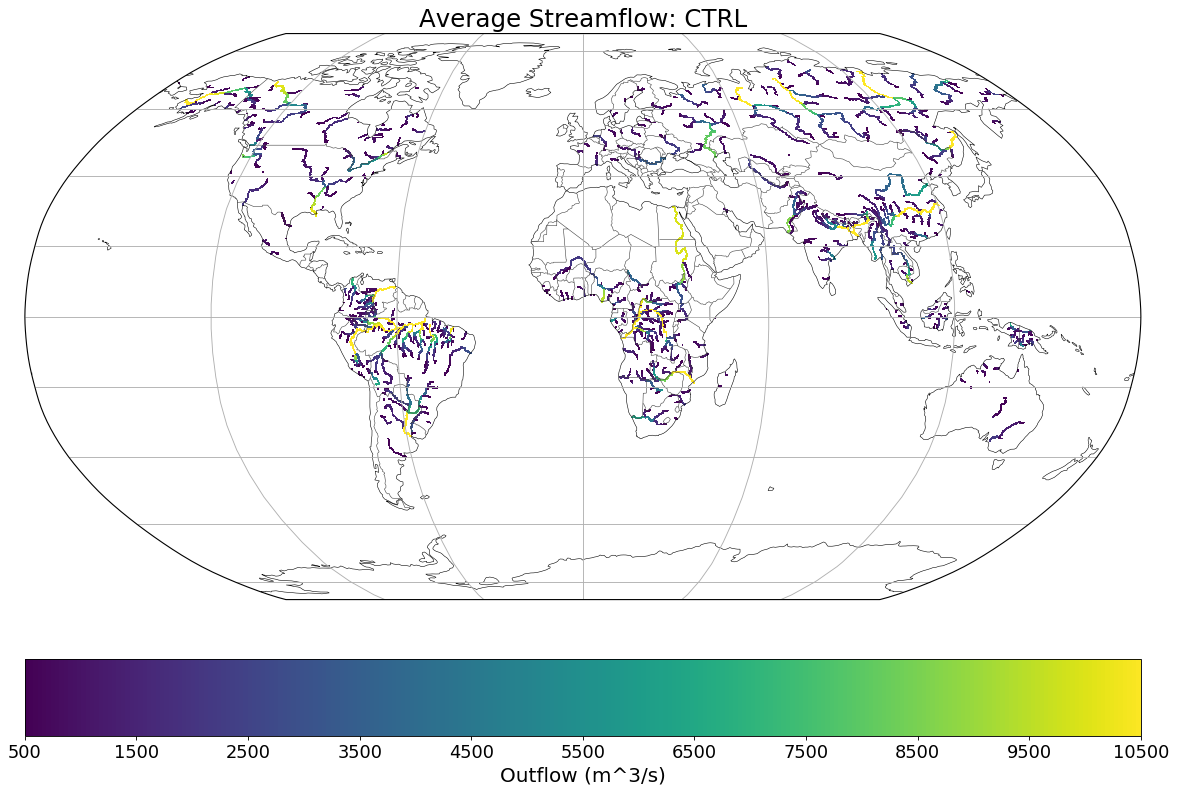

In [20]:
# ---- PLOT AVERAGE STREAMFLOW ---- # 
yrAvgCtrl = np.nanmean(avgCtrl,axis=0)
yrAvgCtrl = np.nanmean(yrAvgCtrl,axis=0)

cutoff = 500 #Threshold for minimum streamflow

#Blank places where seasonal amplitude is below threshold to pick out larger rivers on map
yrAvgCtrl_New = yrAvgCtrl
yrAvgCtrl_New[np.where(yrAvgCtrl<=cutoff)] = np.nan

#Define figure 
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

## --- Set axes and color sections --- 
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()
bounds = np.arange(cutoff,10500+1)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

## --- Create Plot ---
contour_plot = ax.pcolormesh(lon,lat,yrAvgCtrl_New,cmap='viridis',norm=norm,vmin=cutoff,vmax=10500,transform=ccrs.PlateCarree())
#Colorbar 
ax_position = ax.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0+0.05, ax_position.width, 0.06])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Outflow (m^3/s)',fontsize=18)
cbar.ax.tick_params(labelsize=16)
tick_locator = ticker.LinearLocator(numticks=11)
cbar.locator = tick_locator
cbar.update_ticks()
#Other figure options 
ax.set_title('Average Streamflow: CTRL')
ax.title.set_fontsize(22)
ax.coastlines(linewidth=0.5,edgecolor='0.25')
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

plt.show() 

#Save figure
#fig.savefig('/gdata/pritchard2/mdfowler/Flooding-physiology/PythonFigs/SeasonalAmplitude_CTRL.jpg',bbox_inches = 'tight')  #Save figure as jpg



In [15]:
# Create river network mask at CaMa resolution 

lonMask = []
latMask = []

for i in range(len(lat)):
    for j in range(len(lon)):
        if np.isnan(yrAvgCtrl_New[i,j])==False:
            lonMask = np.append(lonMask, j)
            latMask = np.append(latMask, i)

lonMask = lonMask.astype(int)
latMask = latMask.astype(int)


In [56]:
# Save lat/lon into a file
fileName = '/gdata/pritchard2/mdfowler/Flooding-physiology/PythonData/RiverCoordinates_outflow>500.pkl'
f_myFile = open(fileName,'wb')
pickle.dump([lonMask, latMask], f_myFile)
f_myFile.close()

In [35]:
[avgCtrl,avgFull,avgPhys,avgRad]=np.load('/gdata/pritchard2/mdfowler/Flooding-physiology/PythonData/MonthlyAverages.pkl')

yrAvgCtrl = np.nanmean(avgCtrl,axis=0)
yrAvgCtrl = np.nanmean(yrAvgCtrl,axis=0)

print(np.shape(yrAvgCtrl))



(720, 1440)


/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mdfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [40]:

isel=1

print(yrAvgCtrl[latMask[isel],lonMask[isel]])

print(latMask[isel])
print(lonMask[isel])


1016.2649495442707
56
1117


In [6]:
# Read in selected point of raw data
ctrlRegOutflw = fCtrl_outflw.isel(lat=slice(56,56+1), lon=slice(1117,1117+1))

ctrlVals = ctrlRegOutflw.outflw.values

In [8]:
np.shape(ctrlVals)
print(np.nanmean(ctrlVals,axis=0))

[[1018.3025]]
